# HK-RVEA

## Part 0: Set up

### Part 0.1: Set-up

In [ ]:
#stable release of pymoo

In [ ]:
!pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210080 sha256=1f2fc4e94f9b908b27873a7074b885c136991ab158f6900178d4e3509bfbb08a
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
#release candidate

In [ ]:
!pip install --pre -U pymoo

In [ ]:
pip install Platypus-Opt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade rpy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... canceledERROR: Operation cancelled by user


In [ ]:
pip install pygmo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 13.4 MB/s eta 0:00:00


### Part 0.2: Library Importing

In [ ]:
import math
import random
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randint, rand, randn
from scipy.stats import qmc
from scipy.special import comb
from scipy.stats.qmc import LatinHypercube
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.cluster import KMeans
from pymoo.indicators.hv import HV
from pygmo import hypervolume

In [ ]:
import os
import psutil
import sys
import pygmo

import platypus as plat              # multi-objective optimisation framework
import pygmo as pg                   # multi-objective optimisation framework

import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

## Part 1: Input Data and Termination Criterion

In [ ]:
id_nex = 1 # objective no. for inexpensive objective function --> f1 (in fist column)-->index 0
id_ex = 2 # objective no. for expensive objective function --> f2 (in second column)-->index 1
Problems = ['DTLZ2'] # 'DTLZ2','DTLZ5', 'cmmx1' # varies when using different problem --> DTLZ5 or cm-OneMax...

# Input
# M = 2 # number of objectives --> 未來應該改成no_obj = [2,3,4,5....]
no_obj = [2] # 會assign給M
no_var = 20 # number of decision variables
Bounds = np.array([[1] * no_var, [0] * no_var]) # Bounds with 10 columns and 2 rows

# Termination criterion
Latencies = np.array([1,2,4,8,10,15]) # 1,2,4,8,10,15 <-Latency value (ratio of computation time of one evaluation of expensive funciton i to one evaluation of inexpensive function j)
Max_FE_nex = 1000 # maximum number of funciton evaluations for inexpensive objective functions -> how is this number defined?

# for sens
population_size = 50 # remember to modify generate_initial_data too
cross_prob = 0.8 # base = 0.8
mut_prob = 0.1 # base = 0.1 = (1/no_var)

## Part 2: HK-RVEA Algorithm

### Part 2.1: Function Definition

#### generate initial data

In [ ]:
def generate_initial_data(Bounds):

    no_var = Bounds.shape[1] # return the number of columns the array "Bounds" has = no_var
    sampler = qmc.LatinHypercube(d=no_var)
    # sampler = qmc.LatinHypercube(d=no_var, seed = 42) # 這會使得每次initial P都是一樣的
    sample = sampler.random(n=50).reshape(50,no_var)
    round_sample = np.round(sample, 5)
    ub = Bounds[0, :]  # Get the first row of Bounds
    lb = Bounds[1, :]  # Get the second row of Bounds
    scaled_sample = lb + (round_sample * (ub - lb)) # scale the bounds: lb+(ub-lb)*samples(P) generated by LH
    return np.array(scaled_sample)

#### p_objective

In [ ]:
def P_objective(Operation, Problem, M, Input): #(Operation='value', Problem='DTLZ2', M=2, Input=Population) # population is a shape of 50x10

    k = len(Problem) - 1 # the problem is "DTLZ2" --> k=4

    while not Problem[k].isdigit(): # Problem[4].isdigit() returns True -->while not True = while False-->this loop will never be executed as long as the problem is DTLZ2
        k -= 1

    if Problem[:k] == 'DTLZ' or 'cmmx':
        Output,Boundary,Coding = P_DTLZ(Operation, Problem, M, Input)
    else:
        raise Exception('please provide a DTLZ problem')

    return Output, Boundary, Coding

# output: objective FunctionValue for a set of input solutions (P)
# boundary: bounds of decision variables;
# coding: encoding of the decision variables, which represent decision variables in a form that can be processed by an optimisation algorithm

#### p_dtlz

In [ ]:
# 評估objective以得出FunctionValue(output)的function
# the formula for DTLZ2 and 5 would have to modify if M is not 2. the formula for FunctionValue will be differernt when there are more than 2 objectives!
def P_DTLZ(Operation, Problem, M, Input): #(Operation='value', Problem='DTLZ2', M=2, and Input=Population)

    global K
    Boundary = np.nan
    Coding = np.nan

    N = Input.shape[0]  # Number of rows in the Input array
    FunctionValue = np.zeros((N, M)) # initialise it and ensure it has the same shape with Population

    if Operation == 'init':
        # k = max([i for i, c in enumerate(Problem) if not c.isdigit()])
        k = len(Problem) - 1 # 上面那句改成這樣
        K = (no_var - M + 1) * np.ones((7, 1)) # 一個shape(7x1)的array 裡面都是10-M+1 (10 = no_var)
        K = K[int(Problem[k:])] # 應為9
        D = int(M + K - 1) # D = 2 + 9 - 1 = 10
        MaxValue = np.ones((1, D)) # [1,1,1,1,1,1,1,1,1,1]
        MinValue = np.zeros((1, D)) # [0,0,0,0,0,0,0,0,0,0]
        Population = np.random.rand(Input.shape[0], D)
        Population = Population * np.tile(MaxValue, (Input, 1)) + \
            (1 - Population) * np.tile(MinValue, (Input, 1))

        Output = Population
        Boundary = np.vstack((MaxValue, MinValue))
        Coding = 'Real'

    elif Operation == 'value': # 計算FunctionValue
        Population = Input
        K = no_var - M + 1 ### xM vectors是由"最後"K個variables組成的 K = no_var - M + 1 = 9
        FunctionValue = np.zeros((Population.shape[0], M))

        if Problem == 'DTLZ2':
          g = np.sum((Population[:,M-1:] - 0.5)**2, axis = 1)
          for i in range(M):
            if i == 0: # f0 = F_nex in HK-RVEA
              FunctionValue[:,i] = ((1 + g) *
                np.prod(np.cos(0.5 * np.pi * Population[:,:M-1-i]), axis = 1))

            elif i == 1: # f1 = F_ex in HK-RVEA -> # 用f0除以(最後一個var的cos)並乘以第M-2個var的sine
              FunctionValue[:,i] = (FunctionValue[:,i-1] /
                np.prod(np.cos(0.5 * np.pi * Population[:,M-1-i].reshape(-1,1)), axis = 1) *
                np.prod(np.sin(0.5 * np.pi * Population[:,M-i-1].reshape(-1,1)), axis = 1))

            else: # 用前一個f除以(最後一個cosine跟sin)並乘以第M-i-1個sine
              FunctionValue[:,i] = (FunctionValue[:,i-1] /
                (np.prod(np.cos(0.5 * np.pi * Population[:,M-i-1].reshape(-1,1)), axis = 1) *
                np.prod(np.sin(0.5 * np.pi * Population[:,M-i].reshape(-1,1)), axis = 1)) *
                np.prod(np.sin(0.5 * np.pi * Population[:,M-i-1].reshape(-1,1)), axis = 1))

        elif Problem == 'DTLZ5':
          g = np.sum((Population[:,M-1:] - 0.5)**2, axis = 1)
          theta = np.zeros((Population.shape[0], M))
          # theta[:,0] = (0.5 * np.pi * Population[:,0])
          # theta[:,1:] = (np.pi / (4 * (1 + g))) * (1 + 2 * g * Population[:,1:M-1])

          for i in range(M):
            if i == 0: # f0 = F_nex in HK-RVEA
              theta[:,i] = (0.5 * np.pi * Population[:,0])
              FunctionValue[:,i] = ((1 + g) *
                np.prod(np.cos(0.5 * np.pi * theta[:,:M-1-i]), axis = 1))
            elif i == 1: # f1 = F_ex in HK-RVEA -> # 用f0除以(最後一個var的cos)並乘以第M-2個var的sine
              theta[:,i] = (np.pi / (4 * (1 + g))) * (1 + 2 * g * Population[:,i])
              FunctionValue[:,i] = (FunctionValue[:,i-1] /
                np.prod(np.cos(0.5 * np.pi * theta[:,M-1-i]).reshape(-1,1), axis = 1) *
                np.prod(np.sin(0.5 * np.pi * theta[:,M-i-1]).reshape(-1,1), axis = 1))
            else: # 用前一個f除以(最後一個cosine跟sin)並乘以第M-i-1個sine
              theta[:,i] = (np.pi / (4 * (1 + g))) * (1 + 2 * g * Population[:,i])
              FunctionValue[:,i] = (FunctionValue[:,i-1] /
                (np.prod(np.cos(0.5 * np.pi * theta[:,M-i-1].reshape(-1,1)), axis = 1) *
                np.prod(np.sin(0.5 * np.pi * theta[:,M-i].reshape(-1,1)), axis = 1)) *
                np.prod(np.sin(0.5 * np.pi * theta[:,M-i-1].reshape(-1,1)), axis = 1))

        # https://github.com/fcampelo/DEMO/blob/master/Octave-Matlab/DTLZ/dtlz5.m Github Matlab Theta_1的定義

        elif Problem == 'cmmx1': # cm_OneMax
          corr = 0.5 # or -0.5
          # Calculate mapi based on correlation corr
          prob_zero = (1 + corr) / 2
          map = np.random.choice([0, 1], size=(1, 10), p=[prob_zero, 1 - prob_zero])
          # print("map")
          # print(map)

          # Calculate yi = |xi - mapi|
          y = np.abs(Population - map)
          # print("yi")
          # print(y)

          n_x = np.sum(Population, axis =1)
          n_y = np.sum(y, axis = 1)
          # print('nx')
          # print(n_x)
          # print('ny')
          # print(n_y)

          FunctionValue[:,0] = n_x
          FunctionValue[:,1] = n_y
          # print("functionvalue")
          # print(FunctionValue)
        Output = FunctionValue



    elif Operation == 'true':
        if Problem == 'DTLZ2':
            Population = T_uniform(Input, M) # M or M-1??
            for i in range(Population.shape[0]):
                Population[i, :] = Population[i, :] / \
                    np.linalg.norm(Population[i, :])
        elif Problem == 'DTLZ5':
            Population = T_uniform(Input, M - 1) # M or M-1??
            for i in range(Population.shape[0]):
                Population[i, :] = Population[i, :] / np.linalg.norm(Population[i, :])
        Output = Population

    return Output, Boundary, Coding

#### t uniform

In [ ]:
def T_uniform(k, M):

    H = int(np.floor((k * np.prod(np.arange(1, M)))**(1 / (M - 1))))
    while comb(H + M - 1, M - 1) >= k and H > 0:
        H = H - 1
    if comb(H + M, M - 1) <= 2 * k or H == 0:
        H = H + 1
    k = comb(H + M - 1, M - 1)
    Temp = comb(np.arange(1, H + M), M - 1, exact=True) - \
        np.tile(np.arange(0, M - 1), (comb(H + M - 1, M - 1), 1)) - 1
    W = np.zeros((k, M))
    W[:, 0] = Temp[:, 0] - 0
    for i in range(1, M - 1):
        W[:, i] = Temp[:, i] - Temp[:, i - 1]
    W[:, -1] = H - Temp[:, -1]
    W = W / H

    return W

#### evaluate most expensive obj

In [ ]:
def evaluate_most_expensive_obj(Population, Problem, id_ex):

    F,Boundary,Coding = P_objective('value', Problem, 2, Population)
    F = np.array(F) # 跟P同shape的array [f1的FunctionValue,f2的FunctionValue]
    f = F[:,int(id_ex)-1].reshape(-1,1)

    return f,Boundary,Coding # f = FunctionValue from P_objective

In [ ]:
def krvea_init_evaluate_most_expensive_obj(Population, Problem, id_ex):

    F,Boundary,Coding = P_objective('init', Problem, 2, Population)
    F = np.array(F) # 跟P同shape的array [f1的FunctionValue,f2的FunctionValue]
    f = F[:,int(id_ex)-1].reshape(-1,1)


    return f,Boundary,Coding # f = FunctionValue from P_objective = Output from P_DTLZ

#### evaluate least expensive obj



In [ ]:
def evaluate_least_expensive_obj(Population, Problem, id_nex): #id_ex: the objective funciton being evaluated (f1: cheap/ f2: expensive)

    F,Boundary,Coding = P_objective('value', Problem, 2, Population)
    F = np.array(F)
    f = F[:,int(id_nex)-1].reshape(-1,1)

    return f,Boundary,Coding

In [ ]:
def krvea_init_evaluate_least_expensive_obj(Population, Problem, id_nex): #id_ex: the objective funciton being evaluated (f1: cheap/ f2: expensive)

    F,Boundary,Coding = P_objective('init', Problem, 2, Population)
    F = np.array(F)
    f = F[:,int(id_nex)-1].reshape(-1,1)

    return f,Boundary,Coding

#### optimize least expensive

In [ ]:
def optimize_least_expensive(Population, Bounds, latency, Problem, id_nex):

    FE_Max = Population.shape[0] * (latency - 1) #0731把latency改成latency-1
    # 照paper的話應該是|P|*(latency-1) 才對 不過matlab裡面也是寫latency而已

    Archive = call_GA(Population, FE_Max, Bounds, Problem, id_nex) # Population?

    Pop = Archive[:, :-1] # return all rows and columns excepct the last column in Archive

    Fitness = Archive[:, -1] # return all rows and only the last column in Archive


    return Pop, Fitness

#### call ga

In [ ]:
def call_GA(Population, FE_Max, Boundary, Problem, id_nex):

    no_var = Boundary.shape[1]
    F,_,_ = P_objective('value', Problem, 2, Population)
    F = np.array(F)
    FunctionValue = F[:,int(id_nex)-1].reshape(-1,1)

    FE = Population.shape[0] # FE is the number of function evaluation, which takes the number of rows of Population


    Archive = np.hstack((Population, FunctionValue)) # 50x10 hstack 50x1 --> 左10是P 最後一column為FunctionValue(之後的F_nex)

    N = 10 # F_mating's N, P_generator's MaxOffspring parameter

    # performing genetic algorithm (GA)
    while FE < FE_Max: # FE_Max 在 optimize_least_expensive 裡有先定義過才進到call_GA

        MatingPool = F_mating(Population, N) # 產生一個跟Populatoin同size的matingpool 並且都是由population任意塞rows到matingpool(可能會有population重複的rows) 這邊offspring數量是P*(latency-1)

        Coding = 'Real'

        Offspring = P_generator(MatingPool, Boundary, Coding, N, cross_prob, mut_prob)

        Offspring = np.unique(Offspring, axis=0)

        Lia = np.isin(Offspring, Archive[:, :no_var]) # check for the uniqueness of each row in 'Offspring' compared to the solutions in the 'Archive' array --> Lia is a boolean array
        r_unique = np.where(Lia[:, 0] == False)[0]    # get the rows where the column 0 in Lia is False
        Offspring = Offspring[r_unique, :] # those rows not in Archive will be selected and updated to Offspring

        F_Values,_,_ = P_objective('value', Problem, 2, Offspring) # get FunctionValue of the updated Offspring
        FE = FE + Offspring.shape[0] # size of offspring not the P in the algorihtm

        Fitness = F_Values[:, int(id_nex) - 1] # offspring's fitness value
        Fitness = Fitness.reshape(-1, 1)


        Archive = np.vstack((Archive, np.hstack((Offspring, Fitness.reshape(-1,1)))))
        # print("Archive shape (after vstack Archive and hstack Offspring, Fitness):", Archive.shape) #Archive: population 2 columns + FunctionValue 1 column (10,3)
                                                                                                    #hstack: offspring 2 columns + Fitness 1 column (10,3)

        Population = np.vstack((Population, Offspring)) # new population(with initial P) after evolution
        FunctionValue = np.vstack((FunctionValue, Fitness)) # new FunctionValue with initial FunctionValue


        if FunctionValue.shape[0] % 2 == 1:
            FunctionValue = np.vstack((FunctionValue, FunctionValue[0, :]))
            Population = np.vstack((Population, Population[0, :]))
        selection = tournamentSelection(2, FunctionValue)
        selection = np.array(selection)
        selection = np.ravel(selection).astype(int)  # ?
        Population = Population[selection, :]
        FunctionValue = FunctionValue[selection, :]

    return np.array(Archive) # the Archive will be the vstack result of each iteration's Archive (the rows will be extended at each iteration with fixed number of columns)

#### gentic_operation

In [ ]:
def genetic_operation(P, Bounds, latency, Problem, id_nex):

    # N = Population.shape[0] * latency - Population.shape[0] # desired number of offspring --> original code
    N = P.shape[0] * latency - P.shape[0]

    # MatingPool = F_mating(Population, N)
    MatingPool = F_mating(P, N)

    Coding = 'Real'

    Offspring = P_generator(MatingPool, Bounds, Coding, N, cross_prob, mut_prob)

    pop = np.vstack((P, Offspring))

    F,_,_ = P_objective('value', Problem, 2, pop) # F is fitness value of the combined(updated) pop, which has step 1's P and the Offspring generated based on P
    Fitness = F[:, id_nex -1]

    return pop, Fitness

#### select_solutions_for_archive

In [ ]:
def select_solutions_for_archive(P, F_exp, F_nex, id_ex, id_nex):

    S = P.shape[0] # S is the number of rows of P generated by lhs
    F = np.zeros((S, 2))  # set F, the objective function value, to (s,2) shape with all 0

    F_exp = F_exp.reshape(-1,1) # 0722 修改 為了讓取值跟丟值正確 原本F_exp是1D array 這樣會assign第一column的值重複丟給F[:,id_ex-1]
    F[:, id_ex - 1] = F_exp[:, 0] # id_ex = 2 --> column 1 in F would be FunctionValue of f2 --> but in maltab id does not have [:,0] after F_exp?
    F_nex = F_nex.reshape(-1,1) # 0722 修改 同上原因
    F[:, id_nex - 1] = F_nex[:S, 0] # id_nex = 1 --> column 0 in F would be FunctionValue of f1
    # --> only the first 'S' F_nex will be selected (why?)

    A = np.hstack((P, F)) # A will have 4 columns (populations with 2 objectives, F_exp, F_nex)

    return A

#### build_model

In [ ]:
def build_model(A, no_var): # A = A_ex or A_nex; no_var = 10

    X_train = A[:, :no_var] # column 0 ~ 9 in A are P
    Y_train = A[:, no_var:] # column 10 ~  in A are F_nex or F_exp respectively from A_ex or A_nex

    # 0722 為了解決convergence warning (進到if loop後) 因為X_train有重複點 導致distinct idx少於500個
    # unique_indices = np.unique(X_train, axis=0, return_index=True)[1]
    # # Select the corresponding rows from X_train and Y_train
    # X_train = X_train[unique_indices]
    # Y_train = Y_train[unique_indices]

    if A.shape[0] > 500: # if A's number of rows > 500, perform a downsampling step
    # if X_train.shape[0] > 500: # 0724修改 為了讓kmeans有500個distinct idx
        X_temp = np.array([])
        Y_temp = np.array([])

        kmeans = KMeans(n_clusters=500,n_init=1) # use kmeans to randomly select 500 data points on input data X_train
        kmeans.fit(X_train) # 有時會有少於500個不同的idx 因為會有重複的idx?----->convergence warning !!!!!
        # idx = kmeans.labels_


        idx = kmeans.fit_predict(X_train)
        # print("idx from fit predict")
        # print(idx)

        missing = np.setdiff1d(np.arange(0,500),idx)
        # print("missing idx",missing)
        # missing2 = np.setdiff1d(np.arange(0,500),idx2)
        # print("missing idx2",missing2)


        # unique_values, counts = np.unique(idx, return_counts=True)
        # duplicate = unique_values[counts>1]
        # print("duplicate idx",duplicate)
        # print("sorted idx",np.sort(idx))
        # mapping_dict={}
        # unique_labels = np.unique(idx)
        # for i, label in enumerate(unique_labels):
        #     mapping_dict[label]=i
        # mapped_labels = np.array([mapping_dict[label] for label in idx])
        # idx = np.unique(mapped_labels)
        # print("idx after unique",idx)
        # print( "len of idx",len(idx))
        # print("sorted idx",np.sort(idx))

        for n in range(500): # n = 0 to 499
            t = np.where(idx == n)#[0] [0]? t stores the indices where idx equals to n --> indices of the 500 data points assigned to cluster n by kmeans
            pos = np.random.randint(len(t)) # pos is an integer randomly selected in the range 0 to len(t)-1 --> a random position what will be used to select a data point from the cluster assigned to n
            ind = t[pos] # get the element at the position 'pos' from 't' array --> index of a specific data point from the cluster assigned to n
            if len(X_temp) == 0:
                X_temp = X_train[ind, :]
            else:
                X_temp = np.vstack((X_temp, X_train[ind, :]))
            if len(Y_temp) == 0:
                Y_temp= Y_train[ind, :]
            else:
                Y_temp = np.vstack((Y_temp, Y_train[ind, :]))
        X_train = X_temp
        Y_train = Y_temp

    # is below the right way of translation from matlab?
    kernel = RBF(length_scale_bounds=(1e-99, 1e+99))
    model = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True,optimizer=None, n_restarts_optimizer=2000) #fmin_l_bfgs_b
    model.fit(X_train, Y_train)

    return model

#### P_sort

In [ ]:
def P_sort(FunctionValue, operation): # for selecting the nondominated solutions

    # Non-dominated sorting
    # Input: FunctionValue - Population to be sorted (objective space)
    #        operation - Specify sorting only the first front, sorting the first half individuals,
    #                    or sorting all individuals. Default is to sort all individuals.
    # Output: FrontValue - "Front number" where each individual belongs. Front number of unsorted individuals is infinity.
    #         MaxFront - Maximum front number after sorting

    if operation is None:
        kinds = 1
    elif operation == 'half':
        kinds = 2
    elif operation == 'first':
        kinds = 3
    else:
        kinds = 1

    N, M = FunctionValue.shape
    MaxFront = 0

    Sorted = np.zeros(N, dtype=bool)
    rank = np.lexsort((FunctionValue[:, 1], FunctionValue[:, 0])) # sort 2nd key first, and then 1st key
    FunctionValue_sorted = FunctionValue[rank]

    FrontValue = np.full(N, np.inf)


    while ((kinds == 1 and np.sum(Sorted) < N) or
           (kinds == 2 and np.sum(Sorted) < N // 2) or
           (kinds == 3 and MaxFront < 1)): # kinds == 3 and MaxFront < 1 is executed

        MaxFront += 1
        ThisFront = np.zeros(N, dtype=bool) # added

        for i in range(N): # N = 152
            if not Sorted[i]: # check if Sorted[i] is logically false, if it is flase set x = 0; if not false, skip
                x = 0 # the one not sorted is set to x = 0 --> used as a flag to determine whether it is a dominated or nondominated soltuion
                for j in range(N): # i = 0 ~ (N-1)
                    if ThisFront[j]: # if ThisFront[j] is false, set x = 2; if not false, skip

                        x = 2 # the one not True is set to x = 2
                        for j2 in range(1, M): # since M = 2, so this for-loop only execute once --> j2 =2
                            if FunctionValue_sorted[i, j2] < FunctionValue_sorted[j, j2]:
                                x = 0
                                break
                        if x == 2:
                            break
                if x != 2:
                    ThisFront[i] = True
                    Sorted[i] = True


        FrontValue[rank[ThisFront]] = MaxFront # matlab只有寫這樣

    return FrontValue#, MaxFront

#### f_mating

In [ ]:
# evolutionary algorithm
def F_mating(Population, pop_size):

    D = Population.shape[1] # D = the dimension (# of columns) of Population --> 應為2
    N = pop_size # N = desired(max) size of mating pool = 10 (defined in call_GA)

    if Population.shape[0] < pop_size: # if the # of rows in Population < N(=10) 就用population的# of rows重新定義MatingPool的size
        N = pop_size # determine N = the desired size of mating pool = # of rows of Population
        D = Population.shape[1] # determine D = the dimensions(# of columns) of Population
    MatingPool = np.zeros((N, D)) #重新定義的MaitingPool的size

    for i in range(pop_size): # iterate N times to fill the MatingPool
        RandList = np.random.permutation(Population.shape[0]) # generate a random permutation list 根據 Population 的 N 產出"隨機順序"的array (RandList是有 0 to N-1 的隨機排序array)
        MatingPool[i, :] = Population[RandList[0], :] # 因為RandList每次都不一樣 所以MatingPool裡面會有duplicate的rows --> 感覺這種建立matingpool方法怪怪的 不過matlab也是這樣寫

    if N % 2 == 1:
        MatingPool = np.vstack((MatingPool, MatingPool[0, :])) # if N is odd, duplicate the first row of MatingPool and append to the last row to ensure even number of individuals in the pool


    return MatingPool # MatingPool contains selected individuals from Population for offspring generation

#### f_select

In [ ]:
def F_select(FunctionValue, V, theta, refV):


    my_ref = [] # to store reference vectors corresponding to selected individuals
    Empty_ref = [] # to store reference vectors corresponding to empty sets
    APD = [] # to store average perpendicular distance values (APD)
    N, M = FunctionValue.shape # FunctionValue's shape (N,M)
    VN = V.shape[0] # number of row of reference vectors V

    Zmin = np.min(FunctionValue, axis=0) # min of each 'column' in FunctionValue --> will have M values
    Zmax = np.max(FunctionValue, axis=0) # max of each 'column' in FuncitonValue --> will have M values

    # FunctionValue = (FunctionValue - np.tile(Zmin, (FunctionValue.shape[0], 1))) #a new FunctionValue with each value subtracting the Zmin of its corresponding column
    FunctionValue = (FunctionValue - Zmin)

    uFunctionValue = np.empty_like(FunctionValue)

    has_nan = np.isnan(FunctionValue).any()
    has_inf = np.isinf(FunctionValue).any()
    if has_nan:
        print("FunctionValue array contains NaN values.")
    if has_inf:
        print("FunctionValue array contains infinity values.")

    # 0722 修改
    for i in range(N):
      row_norm = np.linalg.norm(FunctionValue[i, :])
      if row_norm < 1e-8:  # Set a small threshold to avoid division by zero
          uFunctionValue[i, :] = np.zeros_like(FunctionValue[i, :])
      else:
          uFunctionValue[i, :] = FunctionValue[i, :] / row_norm



    cosine = np.dot(uFunctionValue, V.T) # calculate consine similarity between normalised FunctionValue and reference vectors
    # # Check if each element of 'cosine' is within the range [-1, 1]
    # within_range = (cosine >= -1) & (cosine <= 1)

    # # Check if all elements of 'cosine' are within the range [-1, 1]
    # all_within_range = np.all(within_range)

    # Check if any elements of 'cosine' are outside the range [-1, 1]
    outside_range = np.any((cosine < -1) | (cosine > 1))

    # print("Are all elements within the range [-1, 1]? ", all_within_range)
    # if outside_range == True:
    #   print("Are any elements outside the range [-1, 1]? ", outside_range)
      # out_of_range_indices = np.where(any_outside_range)
      # out_of_range_values = cosine[out_of_range_indices]
      # np.set_printoptions(threshold=np.inf)
      # print(out_of_range_values)

    # cosine = np.clip(cosine, -1, 1) # 0724 新增 為了處理acosine有invalue value的問題
    acosine = np.arccos(cosine) # 0722 這裡有runtime error: invalid value encountered


    maxc = np.max(cosine, axis = 1)
    maxcidx = np.argmax(cosine, axis = 1) # get the maximum reference vector's index with the max consine similarity for each individual(row)
    # print("maxcdix")
    # print(maxcidx) # 這樣會有重複的index 因為是每row這樣看 可能第一row最大值在index 2 第二row也有可能最大值在index 2 就會有很多重複的indices然後有些missing的indices

    # class_list = [list() for _ in range(VN)] # create an empty class list with the same length as VN's
    # class_list = {'c': [None] * VN}
    class_dict = {k: [] for k in range(VN)} # 0720 應該要這樣?
    for i in range(N):
        class_dict[maxcidx[i]].append(i) # iterate over each individual and append its index to the corresponding class list based on maxcidx


    # below array all modified to list
    Selection = [] # indices of selected individuals
    FitnessValue = [] # fitness values of selected individuals --> what is this for???? it is not used in this function
    EmptySet = [] # indices of empty sets
    NonEmptySet = [] # indices of non-empty sets

    # selection process for each class (maximum reference vector's index)
    for k in range(VN): # iterate over each class
        if len(class_dict[k]) != 0: # check if the class is non-empty, which has individuals assigned to. if it's non-empty, perform selection process
            sub = class_dict[k]
            subFunctionValue = FunctionValue[sub, :]
            subacosine = acosine[sub, k]
            D1 = np.sqrt(np.sum(subFunctionValue**2, axis=1))
            subacosine = subacosine / refV[k]

            # if np.isclose(np.sum(V[k, :]), 1.0):
            if np.sum(V[k, :]) >= 0.9999999 and np.sum(V[k, :]) <= 1.0005: # & seems to have problem: ufunc "bitwise_and" not supported for the input types
                D = D1 * (1 + 10**200 * theta * subacosine) # 1e200 not equal to 10**200 though they are same values, but 1e200 is floatin-point, 10**200 is integer
            else:
                D = D1 * (1 + theta * subacosine)

            mindidx = np.argmin(D)
            mind = D[mindidx] # 0720 added

            Selection.append(sub[mindidx])
            APD.append(mind)
            my_ref.append(V[k,:])
        else:
            EmptySet.append(k)
            Empty_ref.append(V[k,:])

    # Class = [class_list[i] for i in NonEmptySet]

    return Selection, APD, my_ref, Empty_ref

    # Selection = selected individuals
    # APD = selected individuals' correpsonding APD
    # my_ref = selected individuals' corresponding reference vectors
    # F_select provides the most promising individuals selected, there correspdoning APD and reference vectors for further use in EA

#### f_weight

In [ ]:
def F_weight(p1, p2, M): # (99,0,2) from ref_vectors

    N, W = T_weight(int(p1), M) # should take off int()? --> W is from T_weight and is a 100x2 matrix
    if p2 > 0:
        N2, W2 = T_weight(int(p2), M)
        N = N + N2
        W = np.vstack((W, W2 * 0.5 + (1 - 0.5) / M))
    return N, W

    # N = updated # of weight vectors
    # W = combined weight matrix -->for balancing the weight importance of each objective in the optimisation process

#### t_weight

In [ ]:
def T_weight(H, M): # (99,2)

    # N = int(comb(H + M - 1, M - 1, exact=True)) # N = number of weight vectors
    N = math.comb(H+M-1, M-1) # 這樣 N 應為 100 if p1 = H = 99
    Temp = np.zeros((N, M - 1))
    for i in range(N):
        Temp[i, :] = np.arange(1, M) - 1 + i
    W = np.zeros((N, M)) # initialise empty weight matrix with the shape (N,M)
    W[:, 0] = Temp[:, 0] - 0
    for i in range(1, M-1):
        W[:, i] = Temp[:, i] - Temp[:, i - 1] # calculate the weight values for each weight vector in W
    W[:, -1] = H - Temp[:, -1]
    W = W / H # normalise W --> checked, W has the same output as in matlab

    return N, W
    # N = number of weight vectors; W = weight matrix with the shape of (N,M)

In [ ]:
# a=F_weight(99,0,2)

#### p_generator

In [ ]:
def P_generator(MatingPool, Boundary, Coding, MaxOffspring, ProC, ProM):

    N, D = MatingPool.shape # D is dimension in decision space

    MaxOffspring = N


    if Coding == 'Real':
        # simulated binary crossover (SBX)
        # ProC = 0.8 # crossover probability
        # DisC = 20 # crossover's 20 distribution index
        # # polynomial mutation
        # ProM = 1 / D # mutation probability
        # DisM = 20 # mutation's 20 distribution index

        ProC = cross_prob # crossover probability
        DisC = 20 # crossover's 20 distribution index
        # polynomial mutation
        ProM = mut_prob # mutation probability
        DisM = 20 # mutation's 20 distribution index



        Offspring = np.zeros((N, D)) # 0715新增

        # performing SBX to generate offsprings from MatingPool(obtained from populatoin or so-called parents)
        for i in range(0, N, 2):
            beta = np.zeros(D)
            miu = np.random.rand(D)
            beta[miu <= 0.5] = (2 * miu[miu <= 0.5]) ** (1 / (DisC + 1))
            beta[miu > 0.5] = (2 - 2 * miu[miu > 0.5]) ** (-1 / (DisC + 1))
            beta *= (-1) ** np.random.randint(0, 2, D) # 這是要beta乘以相對應的(-1的隨機0,1,2次方)
            beta[np.random.rand(D) > ProC] = 1

            # generate offspring based on above formula
            Offspring[i, :] = [(MatingPool[i, :] + MatingPool[i + 1, :]) / 2] + beta * (MatingPool[i, :] - MatingPool[i + 1, :]) / 2
            Offspring[i + 1, :] = (MatingPool[i, :] + MatingPool[i + 1, :]) / 2 - beta * (MatingPool[i, :] - MatingPool[i + 1, :]) / 2

        # trunacte Offspring, only the first N rows are selected to be Offspring --> ensure size same as MaxOffspring
        Offspring = Offspring[:MaxOffspring, :]

        # handle boundary constraint (max and min values) for each dimension
        if MaxOffspring == 1:
            MaxValue = Boundary[0, :]
            MinValue = Boundary[1, :]
        else:
            MaxValue = np.tile(Boundary[0, :], (MaxOffspring, 1))
            MinValue = np.tile(Boundary[1, :], (MaxOffspring, 1))

        # performing polynomial mutation to diversify the generated Offspring
        k = np.random.rand(MaxOffspring, D)
        miu = np.random.rand(MaxOffspring, D)
        Temp = np.logical_and(k <= ProM, miu < 0.5)
        Offspring[Temp] = Offspring[Temp] + (MaxValue[Temp] - MinValue[Temp]) * ((2 * miu[Temp] + (1 - 2 * miu[Temp]) \
            * (1 - (Offspring[Temp] - MinValue[Temp]) / (MaxValue[Temp] - MinValue[Temp])) ** (DisM + 1)) ** (1 / (DisM + 1)) - 1)
        Temp = np.logical_and(k <= ProM, miu >= 0.5)
        Offspring[Temp] = Offspring[Temp] + (MaxValue[Temp] - MinValue[Temp]) * (1 - (2 * (1 - miu[Temp]) + 2 * (miu[Temp] - 0.5) \
            * (1 - (MaxValue[Temp] - Offspring[Temp]) / (MaxValue[Temp] - MinValue[Temp])) ** (DisM + 1)) ** (1 / (DisM + 1)))

        Offspring[Offspring > MaxValue] = MaxValue[Offspring > MaxValue]
        Offspring[Offspring < MinValue] = MinValue[Offspring < MinValue]

    return Offspring

#### evolve k rvea

In [ ]:
# 此function是個使用Kriging model的EA
# 為了找samples來更新Kriding model
# update_metamodel得到的是my_pop跟empty_new_ref就是更新後的(evolve_k_rvea的)off跟empty_ref_old
# 最後產生off放到run_k_rvea的pop作為下一個iteration的P(去重新被f1,f2評估)
def evolve_K_RVEA(model_ex, model_nex, Archive, Boundary, Empty_ref_old, id_ex, id_nex):

    no_var = Boundary.shape[1] # 10
    Population = Archive[:, :no_var]
    FunctionValue = Archive[:, no_var:]

    maxFE = 1000
    Coding = 'Real'

    Vs = ref_vectors(2)  # Generation of reference vectors
    V = Vs

    N = V.shape[0]
    M = FunctionValue.shape[1]
    Fix_V = Vs
    up_var = M
    alpha = 0.5
    cosineVV = np.dot(V, V.T)
    scosineVV = np.sort(cosineVV, axis=1)[:, ::-1]
    acosVV = np.arccos(scosineVV[:, 1])
    refV = acosVV

    FE = 0
    w = 0

    ERR = np.zeros((Population.shape[0],1)) # ERR's shape (10x1)
    # print("ERR")
    # print(ERR)
    metagen = round(maxFE/N) + 200 # what's this doing?

    # K-RVEA應用kriging model得到uncertainty values (ER)跟APD 並且看是要用diversity或convergence去選下一個iteration的P
    while FE < maxFE:
        # SBX and polynomial mutation
        MatingPool = F_mating(Population, N)

        Offspring = P_generator(MatingPool, Boundary, Coding, N, cross_prob, mut_prob)


        ER = np.zeros((Offspring.shape[0], M))
        # print("offsrping shape", Offspring.shape) #(14,2) so ER will be a shape of (14,2)
        Fitness = np.zeros((Offspring.shape[0], M))

        result_ex, std_ex = model_ex.predict(Offspring, return_std=True) # 用Kriging model的結果來得到unvertainty values (ER)
        Fitness[:, id_ex-1] = result_ex
        ER[:, id_ex-1] = std_ex**2
        # ER[:, id_ex-1] = std_ex

        result_nex, std_nex = model_nex.predict(Offspring, return_std=True) # 用Kriging model的結果來得到uncertainty values (ER)
        Fitness[:, id_nex-1] = result_nex
        ER[:, id_nex-1] = std_nex**2 # if not specify to return std, what is ER actually in matlab??
        # ER[:, id_nex-1] = std_nex**2

        FE += Fitness.shape[0]

        ER = np.mean(ER, axis=1).reshape(-1,1) # mean of each row

        Population = np.vstack((Population, Offspring))
        FunctionValue = np.vstack((FunctionValue, Fitness))

        # 原本ERR是一個(10x1)的matrix但裡面都是0 這樣vstack進去會先是10個0再來是ER的值 感覺怪怪的? 不過在matlab寫這code產出也是這樣
        ERR = np.vstack((ERR, ER)) #ERR(10x1) ER(14x1)

        if M == 2:
            theta = (FE / maxFE) ** alpha

        # matlab有else 但是metagen在matlab被comment掉了 這裡該怎麼辦?
        else:
           theta = M * (w / metagen) ** alpha

        # f_select選出individuals, 其對應的APD, active reference vectors(有被individuals分配到的reference vectors)跟empty_ref(沒被individuals分配到的reference vectors)
        Selection, APD, my_ref, Empty_ref = F_select(FunctionValue, V, theta, refV)
        Population = Population[Selection, :]
        FunctionValue = FunctionValue[Selection, :]
        ERR = ERR[Selection, :]


        if (FE % np.ceil(maxFE * 0.3) == 0 and FE > 0):
            Zmin = np.min(FunctionValue, axis=0)
            Zmax = np.max(FunctionValue, axis=0)

            V = Vs
            V = V * np.tile((Zmax - Zmin) * 1.0, (N, 1))
            tV = V

            for i in range(N):
                V[i, :] = V[i, :] / np.linalg.norm(V[i, :])

            cosineVV = np.dot(V, V.T)
            scosineVV = np.sort(cosineVV, axis=1)[:, ::-1]
            acosVV = np.arccos(scosineVV[:, 1])
            refV = acosVV
        w += 1

    info_update = {'c':[FunctionValue, V, theta, Fix_V, Empty_ref_old, refV, up_var, N, Population, ERR, Boundary]} # 是不是這樣才對???

    off, Empty_ref_old = update_metamodel(info_update) # use update_metamodel to update metamodel with the info_update dictionary that results in off (Offspring) and Empty_ref_old (updated reference vectors)


    off = np.unique(off, axis=0) # remove duplicated rows of off (off means the population selected for re-evaluation with f_ex to update Kriging model)
    current_pop = Population

    P_archive = Archive[:, :no_var]

    Lia = np.all(np.isin(off, P_archive), axis=1) # compare Archive with off (Offspring from updated metamodel) to identify "newly found nondominated solutions"
    r_unique = np.where(Lia == 0)[0]
    off = off[r_unique, :]
    tt = 1
    while len(off) == 0: # to ensure at least one unique offspring is found. if off is empty, go into this loop
        rt = np.random.permutation(current_pop.shape[0])
        off = current_pop[rt[0:1], :] # select random solution from current_pop
        Lia = np.all(np.isin(off, P_archive), axis=1)
        r_unique = np.where(Lia == 0)[0] # check again dupliation of off
        off = off[r_unique, :]
        tt += 1
        if tt > 1000: # check up to 1000 times until a unique solution is found
            break

    return off, Empty_ref_old

    # off = unique offspring solutions; Empty_ref_old = updated reference vectors
    # this EA function includes mating, mutation, evaluation, selection, and metamodel updating
    # with the goal of discovering and improving non-dominated solutions in multi-objective optimization problems.

In [ ]:
def krvea_evolve_K_RVEA(model_ex, model_nex, Population, Archive, Bounds, Int_Col, Vs, Empty_ref_old):

    no_var = Boundary.shape[1] # 10
    Population = Archive[:, :no_var]
    FunctionValue = Archive[:, no_var:]

    maxFE = 1000
    Coding = 'Real'

    Vs = ref_vectors(2)  # Generation of reference vectors
    V = Vs

    N = V.shape[0]
    M = FunctionValue.shape[1]
    Fix_V = Vs
    up_var = M
    alpha = 0.5
    cosineVV = np.dot(V, V.T)
    scosineVV = np.sort(cosineVV, axis=1)[:, ::-1]
    acosVV = np.arccos(scosineVV[:, 1])
    refV = acosVV

    FE = 0
    w = 0

    ERR = np.zeros((Population.shape[0],1)) # ERR's shape (10x1)

    metagen = round(maxFE/N) + 200 # what's this doing?

    # K-RVEA應用kriging model得到uncertainty values (ER)跟APD 並且看是要用diversity或convergence去選下一個iteration的P
    while FE < maxFE:
        # SBX and polynomial mutation
        MatingPool = F_mating(Population, N)

        Offspring = P_generator(MatingPool, Boundary, Coding, N, cross_prob, mut_prob)


        ER = np.zeros((Offspring.shape[0], M))
        # print("offsrping shape", Offspring.shape) #(14,2) so ER will be a shape of (14,2)
        Fitness = np.zeros((Offspring.shape[0], M))

        result_ex, std_ex = model_ex.predict(Offspring, return_std=True) # 用Kriging model的結果來得到unvertainty values (ER)
        Fitness[:, id_ex-1] = result_ex
        ER[:, id_ex-1] = std_ex**2

        result_nex, std_nex = model_nex.predict(Offspring, return_std=True) # 用Kriging model的結果來得到uncertainty values (ER)
        Fitness[:, id_nex-1] = result_nex
        ER[:, id_nex-1] = std_nex**2

        FE += Fitness.shape[0]

        ER = np.mean(ER, axis=1).reshape(-1,1) # mean of each row

        Population = np.vstack((Population, Offspring))
        FunctionValue = np.vstack((FunctionValue, Fitness))

        # 原本ERR是一個(10x1)的matrix但裡面都是0 這樣vstack進去會先是10個0再來是ER的值 感覺怪怪的? 不過在matlab寫這code產出也是這樣
        ERR = np.vstack((ERR, ER)) #ERR(10x1) ER(14x1)

        if M == 2:
            theta = (FE / maxFE) ** alpha

        # matlab有else 但是metagen在matlab被comment掉了 這裡該怎麼辦?
        else:
           theta = M * (w / metagen) ** alpha

        # f_select選出individuals, 其對應的APD, active reference vectors(有被individuals分配到的reference vectors)跟empty_ref(沒被individuals分配到的reference vectors)
        Selection, APD, my_ref, Empty_ref = F_select(FunctionValue, V, theta, refV)
        Population = Population[Selection, :]
        FunctionValue = FunctionValue[Selection, :]
        ERR = ERR[Selection, :]


        if (FE % np.ceil(maxFE * 0.3) == 0 and FE > 0):
            Zmin = np.min(FunctionValue, axis=0)
            Zmax = np.max(FunctionValue, axis=0)

            V = Vs
            V = V * np.tile((Zmax - Zmin) * 1.0, (N, 1))
            tV = V

            for i in range(N):
                V[i, :] = V[i, :] / np.linalg.norm(V[i, :])

            cosineVV = np.dot(V, V.T)
            scosineVV = np.sort(cosineVV, axis=1)[:, ::-1]
            acosVV = np.arccos(scosineVV[:, 1])
            refV = acosVV
        w += 1

    # update model
    # info_update is a dictionary containing information for updating the metamodel
    info_update = {'c':[FunctionValue, V, theta, Fix_V, Empty_ref_old, refV, up_var, N, Population, ERR, Boundary]} # 是不是這樣才對???

    off, Empty_ref_old = update_metamodel(info_update) # use update_metamodel to update metamodel with the info_update dictionary that results in off (Offspring) and Empty_ref_old (updated reference vectors)
    off = np.unique(off, axis=0) # remove duplicated rows of off (off means the population selected for re-evaluation with f_ex to update Kriging model)
    current_pop = Population

    return off, current_pop, Empty_ref_old

#### run_k_rvea

In [ ]:
# run K-RVEA
def run_K_RVEA(model_ex, model_nex, Boundary, A, id_ex, id_nex, empty_ref):

    pop, empty_ref = evolve_K_RVEA(model_ex, model_nex, A, Boundary, empty_ref, id_ex, id_nex)

    return pop, empty_ref

#### ref_vectors

In [ ]:
# there will be |M| p when having M objectives, so when M=2, there are only p1 and p2, but this will have to change in the future
def ref_vectors(M): # p1,p2應該是k-rvea論文裡面地131頁那個用simplex-lattice design弄出來的 但matlab裡面沒有 直接給了這兩串

    p1 = np.array([99, 13, 7, 5, 4, 3, 3, 2, 3]) # how are these values produced? why only 9 numbers?
    p2 = np.array([0, 0, 0, 0, 1, 2, 2, 2, 2]) # how are these values produced? why only 9 numbers?
    p1 = p1[M - 2] # 0715改 在matlab是M-1 所以會是第一個element, 在python要是第0個(M-2)
    p2 = p2[M - 2]
    if M > 10: # suggesting that the reference vectors do not support for more than 10 objectives
        raise ValueError('Define the number of ref vectors parameters for objectives > 10')

    _, Vs = F_weight(p1, p2, M) # only get Vs from W(combined weight matrix) in F_weight --> W is a 100x3 matrix
    # Vs[Vs ==0] = 0.000000001

    # getting reference vectors v1 by p1/(L2-norm of p1) and v2 by p2/(L2-norm of p2)
    for i in range(Vs.shape[0]): # each row of the generated V array is a reference vector
        Vs[i, :] = Vs[i, :] / np.linalg.norm(Vs[i, :]) # each row of the generated V array is normalised

    return Vs # normalised Vs array for given number of objective (normalisation is to ensure reference vecotrs have unit length)

In [ ]:
# a = ref_vectors(2)

#### tournamentSelection

In [ ]:
def tournamentSelection(tournSize, fitness):

    n = len(fitness) # n = length(#) of fitness values for each individual in the population (so n = the number of rows of population)
    winners = []

    # Make sure that the population size is divisible by the tournament size
    if n % tournSize != 0: #tournSize = # of competitors
        raise ValueError('Population size has to be divisible by the tournament size')

    tourn_count = 1
    # Repeat the tournament selection process "tournSize" times
    for i in range(tournSize):
        shuffleOrder = np.random.permutation(n) # create a random set of competitors from 0 to (n-1)
        competitors = shuffleOrder.reshape((n // tournSize, tournSize)) # shape(tournSize,n/tournSize) with numbers 0 to (n-1)

        fitness_comp = fitness[competitors]  # fitness[competitors] will retrieve the value from fitness based on competitor's index (e.g. fitness[0] is 0.2 then the new fitness will be formed based on the fitness[comp's index])

        # The winner is the competitor with the best fitness
        # winner, the competitors with max fitness value, assigned to winFit
        winFit = np.max(fitness[competitors], axis=1) # create new fitness array and compare the fitness value of each row. retrieve the biggest number of each row to winFit array --> winFit = a shape of 10x1 with the biggest fitness value of each row


        winID = np.argmax(fitness[competitors], axis=1) # based on the new fitness array, assign new index for each row (so only 0 and 1 for each row) --> winID = a shape of 10x1 with the index of the biggest value of each row in the new fitness array (fitness[competitors])

        idMap = np.arange(tournSize) * (n // tournSize)

        idMapwinID = np.squeeze(np.array([idMap[w] for w in winID]))

        idMap1 = idMapwinID + np.arange(competitors.shape[0])

        if len(winners) == 0:
          winners = np.hstack(competitors.T.reshape(1,-1)[0,idMap1])
        else:
          winners = np.vstack((winners, competitors.T.reshape(1,-1)[0,idMap1]))

        tourn_count+=1
    # print("winnders in tournament",winners)

    return winners # a list of final winners (individuals with max fitness values)

#### update metamodel

In [ ]:
def update_metamodel(info):

    FunctionValue = info['c'][0]
    V = info['c'][1]
    theta = info['c'][2]
    Fix_V = info['c'][3]
    Empty_ref_old = info['c'][4]
    refV = info['c'][5]
    up_var = info['c'][6]
    N = info['c'][7]
    Population = info['c'][8]
    ERR = info['c'][9]

    M = FunctionValue.shape[1]

    if not isinstance(Empty_ref_old, (np.ndarray, list, tuple)):
        Empty_ref_old = np.array([])  # Initialize as an empty NumPy array
    elif not hasattr(Empty_ref_old, 'shape'):
        raise ValueError("Empty_ref_old should have the attribute 'shape'.")

    _, Empty_ref_new, *_ = reference(FunctionValue, Fix_V, refV, ERR, Population, theta)
    delta = len(Empty_ref_new) - len(Empty_ref_old) # 0720 modified from ...shape[0] to len(Empty_ref_new)

    # find active reference vectors
    _, _, Non_empty_ref, APD_class, ER_class, Population_class = reference(FunctionValue, V, refV, ERR, Population, theta)

    if len(Non_empty_ref) < up_var: # non_empty_ref row # = 10, up_var = 2 -->modified from .shape to len()
        cluster_size = len(Non_empty_ref)
    else:
        cluster_size = up_var # cluster size = 2


    if Population.shape[0] < 2:
        my_pop = Population

    else:
        kmeans = KMeans(n_clusters=cluster_size, init='random')
        kmeans.fit(Non_empty_ref)
        idx = kmeans.labels_
        centroids = kmeans.cluster_centers_
        # Check if any cluster is empty
        empty_clusters = np.where(np.bincount(idx) == 0)[0]

        # might need to delete 58-80 since it's not in matlab, but seems to have error if deleted?
        # If there are empty clusters, create a new cluster with a single point farthest from its centroid
        if len(empty_clusters) > 0:
            max_distance = -1
            farthest_point = None

            for cluster in empty_clusters:
                cluster_points = Non_empty_ref[idx == cluster]
                cluster_centroid = centroids[cluster]
                distances = np.linalg.norm(cluster_points - cluster_centroid, axis=1)
                max_dist_idx = np.argmax(distances)
                if distances[max_dist_idx] > max_distance:
                    max_distance = distances[max_dist_idx]
                    farthest_point = cluster_points[max_dist_idx]

            # Create a new cluster with the farthest point
            new_cluster = np.expand_dims(farthest_point, axis=0)
            centroids[empty_clusters[0]] = farthest_point
            idx[idx == empty_clusters[0]] = cluster_size  # Assign the new cluster label
        my_pop = np.array([])

        for i in range(cluster_size):
          rr = np.where(idx == i)[0] #[0] should be deleted right?

          # 看是要依據convergence還是diversity作為標準去選individuals --> if: 用diversity(最大uncertainty) else:用convergence(最小APD)
          if delta < 0.05 * N: # if delta < 0.05N, it means that it's an empty reference vector(the vector not being assigned any individuals) --> 'convergence' as priority criterion --> choose the one with smallest APD
              need = []
              for j in range(len(rr)):
                  APD_new = APD_class[rr[j]]
                  APD_new, index = np.min(APD_new), np.argmin(APD_new)
                  need.append([rr[j], index, APD_new])
              index_final = np.argmin(np.array(need)[:,-1]) #改
              need = need[index_final]
              sub_class = need[0]
              sub_class_entry = need[1]
              if np.array(my_pop).shape[0] == 0:
                my_pop = Population_class[sub_class][sub_class_entry:]
              else:
                my_pop = np.vstack((my_pop, Population_class[sub_class][sub_class_entry:]))

          else: # delta >= 0.05N means it's an active reference vector --> consider 'diversity' criterion --> choose the one with largest uncertaintu information obtained from kriging model
              need = []
              for j in range(len(rr)):
                  ER_new = ER_class[rr[j]] # 0720 added c
                  ER_new, index = np.max(ER_new), np.argmax(ER_new)
                  need.append([rr[j], index, ER_new])

              index_final = np.argmax(np.array(need)[:,-1]) # 改? got problem here
              need = need[index_final]
              sub_class = need[0]
              sub_class_entry = need[1]
              if np.array(my_pop).shape[0] == 0:
                my_pop = Population_class[sub_class][sub_class_entry:]
              else:
                my_pop = np.vstack((my_pop, Population_class[sub_class][sub_class_entry:]))


    return my_pop, Empty_ref_new

    # my_pop is the population selected for re-evaluation with f_ex for the purpose of updating Kriging model
    # 也就是作為下一個iteration用的P
    # 這個my_pop會給到evolve_k_rvea的off再給到run_k_rvea裡的pop
    # 最後再從algorithm的第6步把pop丟給P 作為下一iteration的P

#### reference

In [ ]:
def reference(fitness, V, refV, ER, Population, theta):

    N, M = fitness.shape # we get the fitness value by FunctionValue in update_metamodel function --> N,M = population shape
    VN = V.shape[0]
    Empty_ref = [] # empty reference vector
    empty_rows = []
    fill_ref = [] # active referece vector

    Zmin = np.min(fitness, axis=0) # get min of each column in fitness
    fitness = (fitness - Zmin) # normalised fitness

    class_dict = {}

    ########## 需要改?
    ## to handle runtime warning (invalid value encountered in divide: ufitness = fitness / np.linalg.norm(fitness, axis=1)[:, np.newaxis])
    row_norm = np.linalg.norm(fitness, axis=1)  # Calculate the Euclidean norm of each row
    mask = row_norm != 0  # Create a mask for non-zero norms
    ufitness = np.zeros_like(fitness)  # Initialize ufitness array

    ufitness[mask, :] = fitness[mask, :] / row_norm[mask, np.newaxis]  # Perform element-wise division for non-zero norms
    ufitness[~mask, :] = np.nan  # Set rows with zero norms to NaN
    ###########

    cosine = ufitness @ V.T # calculate the consince similarity between normalised fitness values and reference vectors
    cosine = np.clip(cosine, -1, 1) # 0724 新增 為了處理acosine有invalue value的問題? but shouldn't be doing this. ufitness cosine should not have invalid value
    acosine = np.arccos(cosine) # calculate arccosine of the cosine similarity values # 0722 runtime warning as in f_select!

    maxc = np.max(cosine, axis=1) # 0719 added
    maxcidx = np.argmax(cosine, axis=1) # get the index of maximum cosine similarity index


    class_dict = {"c": [[] for _ in range(VN)]} # 0720 modified

    for i in range(N):
      class_dict['c'][maxcidx[i]].append(i)

    jj = 0

    Population_class = {}
    APD_class = {}
    ER_class = {}

    for k in range(VN): # check each reference vector k
        if len(class_dict["c"][k]) == 0: # if the reference vector doesn't have any individuals in class_dict, it is a empty reference vector --> if it's an empty vector, use diversity as criterion and select the individuals with maximum uncertainty calculated from Kriging model
            Empty_ref.append(V[k,:])
            empty_rows.append(k)
        else: # otherwise, it's a filled reference vector = active reference vector --> use convergence as criterion and select the individuals with minimum APD
            sub = class_dict['c'][k] # the individual is retrieved from the class to 'sub'
            # the corresponding values, populations, error rate... are assigned to the class-specific lists
            subFunctionValue = fitness[sub, :]
            Population_class[jj] = Population[sub,:] # 0720 modified
            subacosine = acosine[sub, k]
            subacosine = subacosine / refV[k]
            D1 = np.sqrt(np.sum(subFunctionValue ** 2, axis=1))
            APD_class[jj] = D1* (1+(theta*subacosine)) # 0720 modified
            ER_class[jj] = ER[sub,:] # 0720 modified
            fill_ref.append(V[k,:])
            jj += 1

    return class_dict, Empty_ref, fill_ref, \
          APD_class, ER_class, Population_class # 0719 modifed from np.array to dictionaries

    # 現在warning在這function有 在我多放了for lat in range(len(Latencies))這個loop之後
    # convert the class-specific dictionary and lists into numpy arrays
    # these are the relevant information for updating metamodel

### K-RVEA functions

In [ ]:
def corrgauss(theta, d):
    m, n = d.shape  # number of differences and dimension of data

    if np.isscalar(theta):
        theta = np.full(n, theta)
    elif len(theta) != n:
        raise ValueError(f"Length of theta must be 1 or {n}")

    td = d**2 * (-theta)
    r = np.exp(np.sum(td, axis=1))

    if np.ndim(d) == 1:
        d = np.reshape(d, (1, -1))

    if np.ndim(r) == 0:
        r = np.array([r])

    dr = -2 * theta * d * np.repeat(r.reshape(-1, 1), n, axis=1)

    return r, dr

In [ ]:
def regpoly0(S):
    m, n = S.shape
    f = np.ones(m)

    if np.ndim(S) == 1:
        S = np.reshape(S, (1, -1))

    if np.ndim(S) != 2:
        raise ValueError("S must be a 2D array")

    if np.ndim(f) == 0:
        f = np.array([f])

    df = np.zeros(n) if np.size(f) > 1 else None

    return f, df

### Part 2.2: Initialisation

#### Step 1-1: Initialisation

### Part 2.3: Algorithm

#### Step 1-2: Generate Samples

#### Step 2 to 6: Algorithm

In [ ]:
# in matlab
    # 0.0139    0.6895    0.7807    0.1082    0.7365    0.3005    0.4607    0.1836    0.6908    0.8314
    # 0.0393    0.2660    0.7107    0.5031    0.2696    0.8620    0.7138    0.3448    0.2124    0.1335
    # 0.0495    0.9913    0.2411    0.7103    0.5076    0.8559    0.8905    0.3888    0.4452    0.9788
    # 0.0613    0.2171    0.4812    0.9683    0.3263    0.2819    0.9941    0.3780    0.1449    0.1931
    # 0.0912    0.8593    0.6140    0.3268    0.1991    0.1365    0.6356    0.5669    0.1821    0.7701
    # 0.1030    0.6098    0.0808    0.2977    0.6455    0.7344    0.0397    0.4643    0.8946    0.4222
    # 0.1343    0.1428    0.5671    0.2124    0.5206    0.3775    0.8055    0.4934    0.5192    0.0752
    # 0.1440    0.7311    0.7555    0.6026    0.4493    0.9180    0.1466    0.4184    0.8640    0.9547
    # 0.1722    0.8765    0.6658    0.8177    0.0942    0.5323    0.7289    0.9838    0.2955    0.8177
    # 0.1844    0.1230    0.7735    0.3646    0.3144    0.6202    0.0717    0.8539    0.7203    0.7519
    # 0.2124    0.8857    0.0463    0.8211    0.0223    0.7016    0.3550    0.1451    0.1732    0.3737
    # 0.2292    0.3319    0.9211    0.3532    0.9500    0.4063    0.3282    0.9530    0.8249    0.8692
    # 0.2535    0.5823    0.9722    0.1926    0.1058    0.2130    0.4465    0.1327    0.9776    0.0997
    # 0.2639    0.6671    0.2667    0.4167    0.7481    0.5514    0.6062    0.5865    0.0552    0.4997
    # 0.2970    0.5070    0.2069    0.0839    0.4741    0.6147    0.4184    0.8876    0.9910    0.5696
    # 0.3096    0.4550    0.3579    0.4238    0.0758    0.3233    0.1661    0.4226    0.0228    0.9073
    # 0.3332    0.9025    0.3194    0.5882    0.3820    0.4649    0.4987    0.3191    0.4226    0.6104
    # 0.3457    0.8376    0.5876    0.6645    0.3681    0.8903    0.6683    0.5361    0.3130    0.2371
    # 0.3701    0.2237    0.6475    0.1367    0.6187    0.9449    0.8290    0.3295    0.0777    0.3127
    # 0.3868    0.9657    0.9508    0.4547    0.8487    0.0934    0.2871    0.7088    0.4794    0.1072
    # 0.4173    0.3592    0.3933    0.0019    0.2851    0.9610    0.4354    0.5019    0.9436    0.4759
    # 0.4277    0.4853    0.6329    0.2504    0.2551    0.1777    0.6499    0.6580    0.2315    0.7195
    # 0.4403    0.7439    0.1347    0.1785    0.1261    0.0297    0.8612    0.9656    0.0990    0.5903
    # 0.4616    0.6248    0.1505    0.5354    0.4266    0.9889    0.2560    0.6860    0.9060    0.5117
    # 0.4817    0.9323    0.8525    0.6847    0.6700    0.0483    0.5923    0.6270    0.5666    0.6931
    # 0.5074    0.1067    0.7240    0.0401    0.9020    0.7691    0.3152    0.1784    0.8120    0.8462
    # 0.5388    0.3679    0.8609    0.8507    0.8132    0.7589    0.7730    0.8097    0.2597    0.6538
    # 0.5466    0.3951    0.5161    0.5759    0.6295    0.9316    0.2101    0.0053    0.5567    0.1783
    # 0.5691    0.1994    0.6909    0.4678    0.7817    0.1522    0.8556    0.2123    0.6484    0.4599
    # 0.5920    0.1641    0.0018    0.7496    0.8361    0.3959    0.5634    0.5432    0.4096    0.2109
    # 0.6104    0.5302    0.9968    0.5447    0.2195    0.6470    0.5327    0.7277    0.7900    0.5519
    # 0.6374    0.4649    0.1025    0.3009    0.9997    0.4868    0.1030    0.2782    0.3561    0.6310
    # 0.6580    0.8007    0.4614    0.8900    0.8779    0.4430    0.1205    0.7953    0.7715    0.3298
    # 0.6628    0.3194    0.8127    0.1430    0.7649    0.5938    0.7909    0.9188    0.1327    0.7341
    # 0.6950    0.7907    0.0780    0.2746    0.0046    0.5151    0.9650    0.0267    0.5252    0.5307
    # 0.7095    0.7609    0.3764    0.3912    0.0586    0.0633    0.9016    0.2450    0.4924    0.2435
    # 0.7277    0.0712    0.9004    0.7779    0.4090    0.3413    0.0183    0.9380    0.6309    0.2896
    # 0.7539    0.7093    0.5555    0.9269    0.6801    0.8045    0.5402    0.0519    0.6014    0.0530
    # 0.7757    0.0886    0.4460    0.2345    0.5811    0.2551    0.0523    0.7521    0.5821    0.1584
    # 0.7821    0.2978    0.2906    0.6438    0.7024    0.2335    0.1816    0.0610    0.8406    0.9201
    # 0.8156    0.0113    0.8824    0.9534    0.8867    0.5634    0.0946    0.8396    0.3768    0.9881
    # 0.8202    0.6543    0.2292    0.9010    0.2228    0.0155    0.9228    0.2304    0.9293    0.3952
    # 0.8428    0.5593    0.3362    0.7803    0.5475    0.1075    0.6913    0.1006    0.3865    0.4047
    # 0.8681    0.0496    0.5370    0.8607    0.4876    0.2691    0.9503    0.7665    0.6661    0.2710
    # 0.8919    0.9536    0.1850    0.0800    0.9637    0.4355    0.5161    0.6081    0.3396    0.6675
    # 0.9128    0.5695    0.4397    0.0305    0.1449    0.1935    0.2204    0.2963    0.0130    0.0073
    # 0.9287    0.0297    0.1601    0.4911    0.9358    0.8232    0.7561    0.8726    0.1108    0.3542
    # 0.9455    0.2441    0.4068    0.9981    0.5750    0.6968    0.3808    0.6714    0.7197    0.7809
    # 0.9715    0.4367    0.8309    0.6359    0.1653    0.6777    0.3746    0.0881    0.7456    0.0350
    # 0.9992    0.4090    0.0225    0.7356    0.3411    0.7931    0.2797    0.4431    0.2655    0.8931

In [ ]:
# P = np.array([   [0.0139,    0.6895,    0.7807,    0.1082,    0.7365,    0.3005,    0.4607,    0.1836,    0.6908,    0.8314],
#     [0.0393,    0.2660,    0.7107,    0.5031,    0.2696,    0.8620,    0.7138,    0.3448,    0.2124,    0.1335],
#     [0.0495,    0.9913,    0.2411,    0.7103,    0.5076,    0.8559,    0.8905,    0.3888,    0.4452,    0.9788],
#     [0.0613,    0.2171,    0.4812,    0.9683,    0.3263,    0.2819,    0.9941,    0.3780,    0.1449,    0.1931],
#     [0.0912,    0.8593,    0.6140,    0.3268,    0.1991,    0.1365,    0.6356,    0.5669,    0.1821,    0.7701],
#     [0.1030,    0.6098,    0.0808,    0.2977,    0.6455,    0.7344,    0.0397,    0.4643,    0.8946,    0.4222],
#     [0.1343,    0.1428,    0.5671,    0.2124,    0.5206,    0.3775,    0.8055,    0.4934,    0.5192,    0.0752],
#     [0.1440,    0.7311,    0.7555,    0.6026,    0.4493,    0.9180,    0.1466,    0.4184,    0.8640,    0.9547],
#     [0.1722,    0.8765,    0.6658,    0.8177,    0.0942,    0.5323,    0.7289,    0.9838,    0.2955,    0.8177],
#     [0.1844,    0.1230,    0.7735,    0.3646,    0.3144,    0.6202,    0.0717,    0.8539,    0.7203,    0.7519],
#     [0.2124,    0.8857,    0.0463,    0.8211,    0.0223,    0.7016,    0.3550,    0.1451,    0.1732,    0.3737],
#     [0.2292,    0.3319,    0.9211,    0.3532,    0.9500,    0.4063,    0.3282,    0.9530,    0.8249,    0.8692],
#     [0.2535,    0.5823,    0.9722,    0.1926,    0.1058,    0.2130,    0.4465,    0.1327,    0.9776,    0.0997],
#     [0.2639,    0.6671,    0.2667,    0.4167,    0.7481,    0.5514,    0.6062,    0.5865,    0.0552,    0.4997],
#     [0.2970,    0.5070,    0.2069,    0.0839,    0.4741,    0.6147,    0.4184,    0.8876,    0.9910,    0.5696],
#     [0.3096,    0.4550,    0.3579,    0.4238,    0.0758,    0.3233,    0.1661,    0.4226,    0.0228,    0.9073],
#     [0.3332,    0.9025,    0.3194,    0.5882,    0.3820,    0.4649,    0.4987,    0.3191,    0.4226,    0.6104],
#     [0.3457,    0.8376,    0.5876,    0.6645,    0.3681,    0.8903,    0.6683,    0.5361,    0.3130,    0.2371],
#     [0.3701,    0.2237,    0.6475,    0.1367,    0.6187,    0.9449,    0.8290,    0.3295,    0.0777,    0.3127],
#     [0.3868,    0.9657,    0.9508,    0.4547,    0.8487,    0.0934,    0.2871,    0.7088,    0.4794,    0.1072],
#     [0.4173,    0.3592,    0.3933,    0.0019,    0.2851,    0.9610,    0.4354,    0.5019,    0.9436,    0.4759],
#     [0.4277,    0.4853,    0.6329,    0.2504,    0.2551,    0.1777,    0.6499,    0.6580,    0.2315,    0.7195],
#     [0.4403,    0.7439,    0.1347,    0.1785,    0.1261,    0.0297,    0.8612,    0.9656,    0.0990,    0.5903],
#     [0.4616,    0.6248,    0.1505,    0.5354,    0.4266,    0.9889,    0.2560,    0.6860,    0.9060,    0.5117],
#     [0.4817,    0.9323,    0.8525,    0.6847,    0.6700,    0.0483,    0.5923,    0.6270,    0.5666,    0.6931],
#     [0.5074,    0.1067,    0.7240,    0.0401,    0.9020,    0.7691,    0.3152,    0.1784,    0.8120,    0.8462],
#     [0.5388,    0.3679,    0.8609,    0.8507,    0.8132,    0.7589,    0.7730,    0.8097,    0.2597,    0.6538],
#     [0.5466,    0.3951,    0.5161,    0.5759,    0.6295,    0.9316,    0.2101,    0.0053,    0.5567,    0.1783],
#     [0.5691,    0.1994,    0.6909,    0.4678,    0.7817,    0.1522,    0.8556,    0.2123,    0.6484,    0.4599],
#     [0.5920,    0.1641,    0.0018,    0.7496,    0.8361,    0.3959,    0.5634,    0.5432,    0.4096,    0.2109],
#     [0.6104,    0.5302,    0.9968,    0.5447,    0.2195,    0.6470,    0.5327,    0.7277,    0.7900,    0.5519],
#     [0.6374,    0.4649,    0.1025,    0.3009,    0.9997,    0.4868,    0.1030,    0.2782,    0.3561,    0.6310],
#     [0.6580,    0.8007,    0.4614,    0.8900,    0.8779,    0.4430,    0.1205,    0.7953,    0.7715,    0.3298],
#     [0.6628,    0.3194,    0.8127,    0.1430,    0.7649,    0.5938,    0.7909,    0.9188,    0.1327,    0.7341],
#     [0.6950,    0.7907,    0.0780,    0.2746,    0.0046,    0.5151,    0.9650,    0.0267,    0.5252,    0.5307],
#     [0.7095,    0.7609,    0.3764,    0.3912,    0.0586,    0.0633,    0.9016,    0.2450,    0.4924,    0.2435],
#     [0.7277,    0.0712,    0.9004,    0.7779,    0.4090,    0.3413,    0.0183,    0.9380,    0.6309,    0.2896],
#     [0.7539,    0.7093,    0.5555,    0.9269,    0.6801,    0.8045,    0.5402,    0.0519,    0.6014,    0.0530],
#     [0.7757,    0.0886,    0.4460,    0.2345,    0.5811,    0.2551,    0.0523,    0.7521,    0.5821,    0.1584],
#     [0.7821,    0.2978,    0.2906,    0.6438,    0.7024,    0.2335,    0.1816,    0.0610,    0.8406,    0.9201],
#     [0.8156,    0.0113,    0.8824,    0.9534,    0.8867,    0.5634,    0.0946,    0.8396,    0.3768,    0.9881],
#     [0.8202,    0.6543,    0.2292,    0.9010,    0.2228,    0.0155,    0.9228,    0.2304,    0.9293,    0.3952],
#     [0.8428,    0.5593,    0.3362,    0.7803,    0.5475,    0.1075,    0.6913,    0.1006,    0.3865,    0.4047],
#     [0.8681,    0.0496,    0.5370,    0.8607,    0.4876,    0.2691,    0.9503,    0.7665,    0.6661,    0.2710],
#     [0.8919,    0.9536,    0.1850,    0.0800,    0.9637,    0.4355,    0.5161,    0.6081,    0.3396,    0.6675],
#     [0.9128,    0.5695,    0.4397,    0.0305,    0.1449,    0.1935,    0.2204,    0.2963,    0.0130,    0.0073],
#     [0.9287,    0.0297,    0.1601,    0.4911,    0.9358,    0.8232,    0.7561,    0.8726,    0.1108,    0.3542],
#     [0.9455,    0.2441,    0.4068,    0.9981,    0.5750,    0.6968,    0.3808,    0.6714,    0.7197,    0.7809],
#     [0.9715,    0.4367,    0.8309,    0.6359,    0.1653,    0.6777,    0.3746,    0.0881,    0.7456,    0.0350],
#     [0.9992,    0.4090,    0.0225,    0.7356,    0.3411,    0.7931,    0.2797,    0.4431,    0.2655,    0.8931]])

In [ ]:

maxrun = 21 # should be 21

# to store results
solutions_dict = {}
median_pareto_front_dict = {}
results_dict = {}
results_dict_norm = {}

max_values_all = {}
min_values_all = {}

hkrvea_at1 = []
hkrvea_at2 = []
hkrvea_hv = []

reference_point = np.array([3,3]) # ref越小 hv越小

max_of_each_lat = []
min_of_each_lat = []

max_nex_all = []
min_nex_all = []
max_ex_all = []
min_ex_all = []

hkrvea = []



for lat in range(len(Latencies)):
  latency = Latencies[lat]
  Max_FE_ex = round(Max_FE_nex/latency) # maximum number of expensive evaluations for expensive objective functions


  latency_dict = {}
  median_PF_A_all = np.array([])


  max_values_list = []
  min_values_list = []

  # hkrvea_hypervolumes = []

  max_nex_list = []
  min_nex_list = []
  max_ex_list = []
  min_ex_list = []
  for p in range(len(Problems)): # only 2 problems as benchmark
    Problem = Problems[p]

    for run in range(maxrun):
      # step 1-1: initialise itr_count = 0, initialize FEex = 0, FEnex = 0, A = φ and Anex = φ
      itr_count = 0
      FE_ex = 0
      FE_nex = 0
      empty_ref = 0
      A = np.array([])
      A_nex = np.array([])
      A_ex = np.array([])



      for j in range(len(no_obj)): #
          M = no_obj[j]

          # step 1-2: Generate no. of samples (p) by using "latin hypercube"
          np.random.seed(42)
          P = generate_initial_data(Bounds) # the X in the function is now P
          P = np.unique(P,axis=0) # ensure that there are no repeated points in the initial dataset but no need to do this maybe? bc lhs is already generating unique points
          # print("P")
          # print(P)
          # print("P shape[0]", P.shape[0])

          while FE_ex < Max_FE_ex or FE_nex < Max_FE_nex:
              # Step 2: Evaluate P on the most expensive objective function
              F_exp,_,_ = evaluate_most_expensive_obj(P, Problem, id_ex) # F_exp = f, the FunctionValue, from evaluate_most_expensive_obj

              if len(A_ex) == 0:
                  A_ex = np.hstack((P, F_exp))
              else:
                  A_ex = np.vstack((A_ex, np.hstack((P, F_exp))))
              # print("Aex")
              # print(A_ex) # A_ex的最後一個column是F_exp
              # Step 3:
              if latency > 1: # while f_ex(f2) is running, we can afford |P|*(latency-1) evaluations with f_nex(f1)
                  if itr_count == 0: # change from 1 to 0 because the first iteration is 0 not 1 (modified: 0715)
                      # single-objective EA to find solutions for f1 --> maximum no. of evaluations for runnign single-objective EA is |P|*(latency-1) --> purpose of useing single-obj EA is to find promising samples for "training Kriging model of f1" --> select training samples in step 5
                      # single-objective EA only do once, because no. of evaluations available after the first iteration is not sfficient for single-objective optimisation (described in step 7?)
                      X_nex, F_nex = optimize_least_expensive(P, Bounds, latency, Problem, id_nex) # this will call_GA --> simulated binary crossover and polynomial mutation
                      F_nex = F_nex.reshape(-1,1)
                      # print("F_nex in single-objectiv EA")
                      # print(F_nex)

                  else:
                      # crossover and mutation --> to generate samples and evaluate them with f1 (but crossover and mutation again???? already done in call_GA)
                      X_nex, F_nex = genetic_operation(P, Bounds, latency, Problem, id_nex)
                      F_nex = F_nex.reshape(-1,1)
                      # print("F_nex in crossover and mutation")
                      # print(F_nex) # 只有 4 rows generated, 為何????

              else:
                  F_nex,_,_ = evaluate_least_expensive_obj(P, Problem, id_nex)
                  F_nex = F_nex.reshape(-1, 1)
                  X_nex = P

              # add solutions evaluated with f1 to A_nex
              if len(A_nex) == 0:
                  A_nex = np.hstack((X_nex, F_nex))
              else:
                  A_nex = np.vstack((A_ex, np.hstack((X_nex, F_nex))))
              # np.set_printoptions(threshold=np.inf)
              # print("Anex")
              # print(A_nex) # A_nex的最後一column是F_nex


              # Step 4: store all solutions evaluated by both objectives into A
              # thus far, we have solutions evaluated with f1 and f2 in A_nex, A_ex
              FE_ex += P.shape[0]
              FE_nex += P.shape[0] * latency
              # print("FE_ex after step 4:", FE_ex)
              # print("FE_nex after step 4:", FE_nex)

              # and now assign solutions evaluated with f1 and f2 (F_nex and F_exp) to A that has 4 columns [initial P for 2 objectives, F_nex, F_exp]
              if len(A) == 0:
                  A = select_solutions_for_archive(P, F_exp, F_nex, id_ex, id_nex)
              else:
                  A = np.vstack((A, select_solutions_for_archive(P, F_exp, F_nex, id_ex, id_nex)))
              # print("A from select in algorithm")
              # print(A) # A 的左10是P 再來是F_nex 最後一column是F_exp

              # Step 5: Build surrogate model (Kriging = GP) for both objective functions
              model_ex = build_model(A_ex, no_var) # surrogate model for f2 --> A_ex assign給 build_model裡的A
              model_nex = build_model(A_nex, no_var) # surrogate model for f1 --> A_nex assign給 build_model裡的A
              # in surrogate model, we don't use same samples used in getting F_exp and F_nex for training the surrogate
              # the size of A_nex > A_ex, so the no. of training samples for building surrogate models is differenrt for f1 and f2
              # we train model_ex by using solutions(FunctionValue?) in A_ex; train model_nex by using solutions in A_nex
              # but the no. of solutions in both A_ex and A_nex increase with the FE_ex and FE_nex
              # therefore, we select predifined Max no. of samples (masFE = 1000 in evolve_k_rvea) --> this is set arbitrary, and needs to be adaptive, so this should be considered as future work
              # so far, we have selected the training data and built the surrogates for f1 and f2


              # Step 6: Run some surrogate-assisted algorithm (e.g., K-RVEA) to find the samples to be evaluated
              # run a multiobjective EA (RVEA) to find smaples for updating the surrogates
              # samples are selected to update surrogates with the strategy from K-RVEA, which selected samples based on diversity(uncertainty values obetained from the Kriging models) or convergence(APD)
              # reference vectors are used for the needs of "diversity"
              P,_ = run_K_RVEA(model_ex, model_nex, Bounds, A, id_ex, id_nex, empty_ref) # select sample P to be evlauated in next iteration's step 2 onward

              itr_count += 1
              # print(f"finish {itr_count} iteration")

          # output (enter here after 1 run)
          # print("FE_ex after 1 run", FE_ex)
          # print("FE_nex after 1 run", FE_nex)
          non = P_sort(A[:, no_var:], 'first') == 1  # A[:,no_var:] is actually same as 'FunctionValue'-->(nex's, ex's)
          # print("non",non)
          PF_A = A[non, :] # nondominated solutions = Pareto Front
          # print(f"after {run+1} run's PF_A")
          # print("PF_A[:,no_var:]")
          # print(PF_A[:,no_var:])

          max_nex = np.max(PF_A[:,no_var:][:,0])
          min_nex = np.min(PF_A[:,no_var:][:,0])
          max_ex = np.max(PF_A[:,no_var:][:,1])
          min_ex = np.min(PF_A[:,no_var:][:,1])
          max_nex_list.append(max_nex)
          # print(f"max list of f1 after {run+1} run of latency {latency}")
          # print(max_nex_list)
          min_nex_list.append(min_nex)
          # print(f"min list of f1 after {run+1} run of latency {latency}")
          # print(min_nex_list)
          max_ex_list.append(max_ex)
          # print(f"max list of f2 after {run+1} run of latency {latency}")
          # print(max_ex_list)
          min_ex_list.append(min_ex)
          # print(f"min list of f2 after {run+1} run of latency {latency}")
          # print(min_ex_list)

          # store the results of each run in a dictionary
          latency_dict[f"Run {run+1}"]= PF_A[:,no_var:]
          # print("latency_dict")
          # print(latency_dict)


          # # Calculate median attainment
          # distances_obj1 = np.linalg.norm(np.subtract(PF_A[:, no_var:][:, 0].reshape(-1,1),reference_point[0]))
          # distances_obj2 = np.linalg.norm(np.subtract(PF_A[:, no_var:][:, 1].reshape(-1,1),reference_point[1]))

          # hkrvea_median_attainment_obj1 = np.median(distances_obj1)
          # hkrvea_median_attainment_obj2 = np.median(distances_obj2)

          # hkrvea_at1.append(hkrvea_median_attainment_obj1)
          # hkrvea_at2.append(hkrvea_median_attainment_obj2)
          median_PF_A = PF_A[:,no_var:]
          # print("median PF_A of each run")
          # print(median_PF_A)

          if len(median_PF_A_all) == 0:
            median_PF_A_all = median_PF_A
          else:
            median_PF_A_all = np.vstack((median_PF_A_all, median_PF_A))
          # print("median PF_A_all for each latency, should have 21 rows and 2 columns in the end")
          # print(median_PF_A_all)
          # print("median PF_A_All shape",median_PF_A_all.shape)


          # # Calculate median hypervolume
          # ind = HV(ref_point=reference_point)
          # hv = ind(PF_A[:,no_var:])
          # hkrvea_hypervolumes.append(hv)
          # print(f"hypervolumes from latency {latency} after {run+1} runs:", hkrvea_hypervolumes)
          # print("count of hkrvea_hypervolumes:", len(hkrvea_hypervolumes))

          print(f"Finish latency {latency}'s {run + 1} run") # each run ends here

    # will enter here after a latency finishes its 21 runs
    solutions_dict[f"Latency {latency}"] = {'A': A[:,no_var:], 'PF_A': PF_A[:, no_var:]}
    # print("solutions_dict, the results from last run of each latency")
    # print(solutions_dict)

    median_pareto_front_dict[f'Latency {latency}'] = median_PF_A_all
    # print('median_pareto_front_dict')
    # print(median_pareto_front_dict)


    results_dict[f"Latency {latency}"] = latency_dict   # 這個dictionary有所有latency及其21runs的pareto front --> 結構為'Latency _' -->'Run _' --> array(每run的pareto front)
    # print("results_dict")
    # print(results_dict)
    max_nex_all.append(np.max(max_nex_list))
    # print(f"max of f1 of latencies {Latencies}")
    # print(max_nex_all)
    min_nex_all.append(np.min(min_nex_list))
    # print(f"min of f1 of latencies {Latencies}")
    # print(min_nex_all)
    max_ex_all.append(np.max(max_ex_list))
    # print(f"max of f2 of latencies {Latencies}")
    # print(max_ex_all)
    min_ex_all.append(np.min(min_ex_list))
    # print(f"min of f2 of latencies {Latencies}")
    # print(min_ex_all)

#     hkrvea_median_hypervolume = np.median(hkrvea_hypervolumes)
#     hkrvea_hv.append(hkrvea_median_hypervolume)
#     print(f"hkrvea_hv (should have {len(Latencies)} median hv for latencies {Latencies}):",hkrvea_hv)
# for i, lat in enumerate(Latencies):
#   print(f"Median Hypervolume for latency {lat}: {hkrvea_hv[i]}")



Finish latency 1's 1 run
Finish latency 1's 2 run
Finish latency 1's 3 run
Finish latency 1's 4 run
Finish latency 1's 5 run
Finish latency 1's 6 run


<ipython-input-99-c65c7a2b5ac8>:54: RuntimeWarning: invalid value encountered in arccos
  acosine = np.arccos(cosine) # 0722 這裡有runtime error: invalid value encountered


Finish latency 1's 7 run
Finish latency 1's 8 run
Finish latency 1's 9 run
Finish latency 1's 10 run
Finish latency 1's 11 run
Finish latency 1's 12 run
Finish latency 1's 13 run
Finish latency 1's 14 run
Finish latency 1's 15 run
Finish latency 1's 16 run
Finish latency 1's 17 run
Finish latency 1's 18 run
Finish latency 1's 19 run
Finish latency 1's 20 run
Finish latency 1's 21 run


<ipython-input-96-04bb2017401a>:18: ConvergenceWarning: Number of distinct clusters (499) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  kmeans.fit(X_train) # 有時會有少於500個不同的idx 因為會有重複的idx?----->convergence warning !!!!!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (499) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Finish latency 2's 1 run
Finish latency 2's 2 run
Finish latency 2's 3 run
Finish latency 2's 4 run
Finish latency 2's 5 run
Finish latency 2's 6 run


<ipython-input-96-04bb2017401a>:18: ConvergenceWarning: Number of distinct clusters (499) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  kmeans.fit(X_train) # 有時會有少於500個不同的idx 因為會有重複的idx?----->convergence warning !!!!!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (499) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Finish latency 2's 7 run
Finish latency 2's 8 run
Finish latency 2's 9 run
Finish latency 2's 10 run


<ipython-input-96-04bb2017401a>:18: ConvergenceWarning: Number of distinct clusters (499) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  kmeans.fit(X_train) # 有時會有少於500個不同的idx 因為會有重複的idx?----->convergence warning !!!!!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (499) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Finish latency 2's 11 run
Finish latency 2's 12 run
Finish latency 2's 13 run
Finish latency 2's 14 run
Finish latency 2's 15 run
Finish latency 2's 16 run
Finish latency 2's 17 run
Finish latency 2's 18 run


<ipython-input-96-04bb2017401a>:18: ConvergenceWarning: Number of distinct clusters (499) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  kmeans.fit(X_train) # 有時會有少於500個不同的idx 因為會有重複的idx?----->convergence warning !!!!!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (499) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Finish latency 2's 19 run
Finish latency 2's 20 run
Finish latency 2's 21 run
Finish latency 4's 1 run
Finish latency 4's 2 run


<ipython-input-99-c65c7a2b5ac8>:54: RuntimeWarning: invalid value encountered in arccos
  acosine = np.arccos(cosine) # 0722 這裡有runtime error: invalid value encountered


Finish latency 4's 3 run
Finish latency 4's 4 run
Finish latency 4's 5 run
Finish latency 4's 6 run
Finish latency 4's 7 run
Finish latency 4's 8 run
Finish latency 4's 9 run
Finish latency 4's 10 run
Finish latency 4's 11 run
Finish latency 4's 12 run
Finish latency 4's 13 run
Finish latency 4's 14 run
Finish latency 4's 15 run
Finish latency 4's 16 run
Finish latency 4's 17 run
Finish latency 4's 18 run
Finish latency 4's 19 run
Finish latency 4's 20 run
Finish latency 4's 21 run
Finish latency 8's 1 run
Finish latency 8's 2 run
Finish latency 8's 3 run
Finish latency 8's 4 run


<ipython-input-99-c65c7a2b5ac8>:54: RuntimeWarning: invalid value encountered in arccos
  acosine = np.arccos(cosine) # 0722 這裡有runtime error: invalid value encountered


Finish latency 8's 5 run
Finish latency 8's 6 run
Finish latency 8's 7 run
Finish latency 8's 8 run
Finish latency 8's 9 run
Finish latency 8's 10 run
Finish latency 8's 11 run
Finish latency 8's 12 run
Finish latency 8's 13 run
Finish latency 8's 14 run
Finish latency 8's 15 run
Finish latency 8's 16 run
Finish latency 8's 17 run
Finish latency 8's 18 run
Finish latency 8's 19 run
Finish latency 8's 20 run
Finish latency 8's 21 run
Finish latency 10's 1 run
Finish latency 10's 2 run
Finish latency 10's 3 run
Finish latency 10's 4 run
Finish latency 10's 5 run
Finish latency 10's 6 run
Finish latency 10's 7 run
Finish latency 10's 8 run
Finish latency 10's 9 run
Finish latency 10's 10 run
Finish latency 10's 11 run
Finish latency 10's 12 run
Finish latency 10's 13 run
Finish latency 10's 14 run
Finish latency 10's 15 run
Finish latency 10's 16 run
Finish latency 10's 17 run


<ipython-input-99-c65c7a2b5ac8>:54: RuntimeWarning: invalid value encountered in arccos
  acosine = np.arccos(cosine) # 0722 這裡有runtime error: invalid value encountered


Finish latency 10's 18 run
Finish latency 10's 19 run
Finish latency 10's 20 run
Finish latency 10's 21 run
Finish latency 15's 1 run
Finish latency 15's 2 run
Finish latency 15's 3 run
Finish latency 15's 4 run
Finish latency 15's 5 run
Finish latency 15's 6 run
Finish latency 15's 7 run
Finish latency 15's 8 run
Finish latency 15's 9 run
Finish latency 15's 10 run
Finish latency 15's 11 run
Finish latency 15's 12 run
Finish latency 15's 13 run
Finish latency 15's 14 run
Finish latency 15's 15 run
Finish latency 15's 16 run
Finish latency 15's 17 run
Finish latency 15's 18 run
Finish latency 15's 19 run
Finish latency 15's 20 run
Finish latency 15's 21 run


In [ ]:
# will enter here after all latencies finish their 21 runs (after the whole algorithm finish)
overall_max_nex = np.max(max_nex_all)
# print(f"overall max for f1 of latencies {Latencies}")
# print(overall_max_nex)

overall_min_nex = np.min(min_nex_all)
# print(f"overall min for f1 of latency {Latencies}")
# print(overall_min_nex)

overall_max_ex = np.max(max_ex_all)
# print(f"overall max for f2 of latency {Latencies}")
# print(overall_max_ex)

overall_min_ex = np.max(min_ex_all)
# print(f"overall min for f2 of latency {Latencies}")
# print(overall_min_ex)

max_values = np.array([overall_max_nex, overall_max_ex])
min_values = np.array([overall_min_nex, overall_min_ex])

# save pareto fronts across all latencies and runs to 'results_dict'
for latency_key in results_dict.keys():
  runs_dict = results_dict[latency_key]
  for run_key in runs_dict.keys():
    PF = runs_dict[run_key]
print("original PF_A")
print(results_dict)

# normalise all the pareto fronts and save them to 'results_dict_norm'
for latency_key in results_dict.keys():
  runs_dict = results_dict[latency_key]
  norm_runs_dict = {}
  for run_key in runs_dict.keys():
    PF = runs_dict[run_key]
    # print("PF from results dict {run_key}", PF)
    PF_A_norm = (max_values - PF)/ (max_values - min_values)
    # print("norm PF", PF_A)
    norm_runs_dict[run_key] = PF_A_norm
  results_dict_norm[latency_key] = norm_runs_dict
print("normalised PF_A")
print(results_dict_norm)


# calculate hypervolume
hkrvea_hypervolumes_median=[]
for latency_key in results_dict_norm.keys():
  runs_dict = results_dict_norm[latency_key]
  hkrvea_hypervolumes = []

  for run_key in runs_dict.keys():
    PF = runs_dict[run_key]
    # print("PF from {latency_key} {run_key} norm",PF)
    ind = HV(ref_point = reference_point)
    hv = ind(PF)
    hv = hv / np.prod(reference_point)
    # print(f"hv of {latency_key} {run_key}", hv)

    # hyp = pg.hypervolume(PF.values)
    # hyp.compute([3, 3])
    # hv = hyp.compute([3, 3]) / np.prod([3, 3])

    hkrvea_hypervolumes.append(hv)
  print(f"hypervolumes for {latency_key}",hkrvea_hypervolumes)

  hkrvea_median_hypervolume = np.median(hkrvea_hypervolumes)
  hkrvea_hypervolumes_median.append(hkrvea_median_hypervolume)
  print(f"median hypervoluems for {latency_key}: {hkrvea_median_hypervolume}")
  print("hkrvea_hypervolumes_median",hkrvea_hypervolumes_median)
  print("------------")
  # print(f"hypervoluems from latency {latency_key}:")
  # print(hkrvea_hypervolumes)

original PF_A
{'Latency 1': {'Run 1': array([[1.84448320e+00, 1.08181003e+00],
       [1.25029738e+00, 1.40994797e+00],
       [9.77856572e-01, 1.78935240e+00],
       [8.49117699e-01, 2.08684996e+00],
       [8.17466218e-01, 2.10378468e+00],
       [1.32033528e-02, 2.36772628e+00],
       [1.98609602e+00, 1.45185878e-03],
       [1.89006078e+00, 7.37240365e-03],
       [2.01025184e+00, 4.29397929e-04],
       [2.03012131e+00, 0.00000000e+00],
       [3.98398538e-01, 2.29974299e+00],
       [1.45288833e-16, 2.37274671e+00]]), 'Run 2': array([[1.57647399e+00, 1.29954949e+00],
       [1.33822371e+00, 1.53577069e+00],
       [1.32696579e+00, 1.77710034e+00],
       [1.24805257e-01, 2.22387891e+00],
       [1.75734061e+00, 0.00000000e+00],
       [1.78961814e-01, 1.93579533e+00],
       [1.37815912e-16, 2.25070464e+00],
       [1.71775056e+00, 7.57192402e-04]]), 'Run 3': array([[1.38955395e+00, 1.21762823e+00],
       [1.15140855e+00, 1.66354602e+00],
       [1.77704798e+00, 0.00000000e+00

In [ ]:
A = np.array([0.4883567 , 0.7071922])
from pymoo.indicators.hv import HV

ref_point = np.array([1.2, 1.2])

ind = HV(ref_point=ref_point)
print("HV", ind(A))

HV 0.3507033690577399


In [ ]:
B = np.array([[0.4883567 , 0.7071922 ],
       [0.65317858, 0.61837684],
       [0.72875125, 0.51568545],
       [0.76446227, 0.43516336],
       [0.77324211, 0.43057972],
       [0.99633751, 0.35914005],
       [0.44907456, 0.99960703],
       [0.47571388, 0.99800455],
       [0.44237395, 0.99988378],
       [0.43686234, 1.        ],
       [0.88948777, 0.37754072],
       [1.        , 0.35778119]])
# C = np.array([0,1])
ref_point = np.array([1.2, 1.2])

ind = HV(ref_point=ref_point)
print(B)
print("HV", ind(B))


[[0.4883567  0.7071922 ]
 [0.65317858 0.61837684]
 [0.72875125 0.51568545]
 [0.76446227 0.43516336]
 [0.77324211 0.43057972]
 [0.99633751 0.35914005]
 [0.44907456 0.99960703]
 [0.47571388 0.99800455]
 [0.44237395 0.99988378]
 [0.43686234 1.        ]
 [0.88948777 0.37754072]
 [1.         0.35778119]]
HV 0.5155131160828708


### Save data to files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the base path for results
base_path = f"/content/drive/My Drive/BDP/python code/results/"

In [ ]:
# Create a directory for the specific problem
problem_directory = os.path.join(base_path, f"{Problem} {no_var}var {population_size}pop {cross_prob}cp {mut_prob}mp/")
os.makedirs(problem_directory, exist_ok=True)  # Creates the directory if it doesn't exist

In [ ]:
# solutions_dict
flattened_data = []
for latency_key, latency_data in solutions_dict.items():
    for solution_key, solution_data in latency_data.items():
        flattened_data.append({'Latency': latency_key, 'Solution': solution_key, 'Data': solution_data})

# Create a DataFrame from the flattened data
df = pd.DataFrame(flattened_data)

# Save to CSV
csv_file_name_solutions_dict = f'{Problem} {no_var}var {latency} solutions_dict.csv'
full_csv_file_path = os.path.join(problem_directory, csv_file_name_solutions_dict)
df.to_csv(full_csv_file_path, index=False)

In [ ]:
# solutions_dict
# transform the csv back to dictionary
solutions_dict = {}
for _, row in df.iterrows():
    latency_key = row['Latency']
    solution_key = row['Solution']
    data = np.array(row['Data'])

    if latency_key not in solutions_dict:
        solutions_dict[latency_key] = {}

    solutions_dict[latency_key][solution_key] = data
solutions_dict

{'Latency 1': {'A': array([[3.00530256e+00, 5.47663926e-02],
         [2.75484142e+00, 1.00741020e-01],
         [2.17007020e+00, 1.89768763e-01],
         ...,
         [2.32801551e+00, 1.99696373e-03],
         [2.89217789e+00, 4.77178894e-07],
         [2.50595044e+00, 1.42001937e-04]]),
  'PF_A': array([[1.59031506e+00, 9.07761973e-01],
         [1.23599560e+00, 1.65294111e+00],
         [1.00173890e+00, 1.78517992e+00],
         [4.58334029e-01, 1.88314681e+00],
         [3.32621099e-01, 2.13083756e+00],
         [1.74688880e+00, 1.48154230e-03],
         [1.85481793e+00, 7.79317026e-05],
         [1.95396261e+00, 0.00000000e+00],
         [1.92402396e+00, 2.67117636e-05],
         [1.36054063e-16, 2.22193147e+00],
         [3.59143520e-02, 2.15879865e+00]])},
 'Latency 2': {'A': array([[2.73098931e+00, 5.25139654e-02],
         [3.10015793e+00, 1.43320339e-01],
         [2.60568498e+00, 1.68744131e-01],
         [2.74908151e+00, 2.72243420e-01],
         [2.78183516e+00, 3.639093

In [ ]:
# results_dict
# save dicitonary results to csv
flattened_data = []
for latency_key, latency_data in results_dict.items():
    for run_key, run_data in latency_data.items():
        flattened_data.append({'Latency': latency_key, 'Run': run_key, 'Pareto Front': run_data})

# Create a DataFrame from the flattened data
df = pd.DataFrame(flattened_data)

# Save to CSV
csv_file_name_results_dict = f'{Problem} {no_var}var {latency} results_dict.csv'
full_csv_file_path = os.path.join(problem_directory, csv_file_name_results_dict)
df.to_csv(full_csv_file_path, index=False)

In [ ]:
# results_dict
# transform the csv back to dictionary
results_dict = {}
for _, row in df.iterrows():
    latency_key = row['Latency']
    run_key = row['Run']
    data = np.array(row['Pareto Front'])

    if latency_key not in results_dict:
        results_dict[latency_key] = {}

    results_dict[latency_key][run_key] = data
results_dict

{'Latency 1': {'Run 1': array([[1.84448320e+00, 1.08181003e+00],
         [1.25029738e+00, 1.40994797e+00],
         [9.77856572e-01, 1.78935240e+00],
         [8.49117699e-01, 2.08684996e+00],
         [8.17466218e-01, 2.10378468e+00],
         [1.32033528e-02, 2.36772628e+00],
         [1.98609602e+00, 1.45185878e-03],
         [1.89006078e+00, 7.37240365e-03],
         [2.01025184e+00, 4.29397929e-04],
         [2.03012131e+00, 0.00000000e+00],
         [3.98398538e-01, 2.29974299e+00],
         [1.45288833e-16, 2.37274671e+00]]),
  'Run 2': array([[1.57647399e+00, 1.29954949e+00],
         [1.33822371e+00, 1.53577069e+00],
         [1.32696579e+00, 1.77710034e+00],
         [1.24805257e-01, 2.22387891e+00],
         [1.75734061e+00, 0.00000000e+00],
         [1.78961814e-01, 1.93579533e+00],
         [1.37815912e-16, 2.25070464e+00],
         [1.71775056e+00, 7.57192402e-04]]),
  'Run 3': array([[1.38955395e+00, 1.21762823e+00],
         [1.15140855e+00, 1.66354602e+00],
         [

In [ ]:
# results_dict_norm
# save dicitonary results to csv
flattened_data = []
for latency_key, latency_data in results_dict_norm.items():
    for run_key, run_data in latency_data.items():
        flattened_data.append({'Latency': latency_key, 'Run': run_key, 'Normalized Pareto Front': run_data})

# Create a DataFrame from the flattened data
df = pd.DataFrame(flattened_data)

# Save to CSV
csv_file_name_results_dict_norm = f'{Problem} {no_var}var {latency} results_dict_norm.csv'
full_csv_file_path = os.path.join(problem_directory, csv_file_name_results_dict_norm)
df.to_csv(full_csv_file_path, index=False)

In [ ]:
# results_dict_norm
# transform the csv back to dictionary
results_dict_norm = {}
for _, row in df.iterrows():
    latency_key = row['Latency']
    run_key = row['Run']
    data = np.array(row['Normalized Pareto Front'])

    if latency_key not in results_dict_norm:
        results_dict_norm[latency_key] = {}

    results_dict_norm[latency_key][run_key] = data
results_dict_norm

{'Latency 1': {'Run 1': array([[0.4883567 , 0.7071922 ],
         [0.65317858, 0.61837684],
         [0.72875125, 0.51568545],
         [0.76446227, 0.43516336],
         [0.77324211, 0.43057972],
         [0.99633751, 0.35914005],
         [0.44907456, 0.99960703],
         [0.47571388, 0.99800455],
         [0.44237395, 0.99988378],
         [0.43686234, 1.        ],
         [0.88948777, 0.37754072],
         [1.        , 0.35778119]]),
  'Run 2': array([[0.56270008, 0.64825781],
         [0.6287886 , 0.58432107],
         [0.63191145, 0.51900165],
         [0.96538013, 0.39807445],
         [0.51252928, 1.        ],
         [0.95035758, 0.47604851],
         [1.        , 0.39081368],
         [0.52351121, 0.99979505]]),
  'Run 3': array([[0.61455005, 0.67043101],
         [0.68060947, 0.5497368 ],
         [0.50706263, 1.        ],
         [0.75487573, 0.49167247],
         [1.        , 0.27752148],
         [0.97715039, 0.40493106],
         [0.97223942, 0.46425852]]),
  'Run 4'

In [ ]:
# Save max_values to a CSV file
csv_file_path_max = f'{Problem} {no_var}var {latency} max_values.csv'
full_csv_file_path_max = os.path.join(problem_directory, csv_file_path_max)
np.savetxt(full_csv_file_path_max, max_values, delimiter=',')

# Save min_values to a CSV file
csv_file_path_min = f'{Problem} {no_var}var {latency} min_values.csv'
full_csv_file_path_min = os.path.join(problem_directory, csv_file_path_min)
np.savetxt(full_csv_file_path_min, min_values, delimiter=',')

In [ ]:
# Read max_values from CSV
csv_file_path_max = f'{Problem} {no_var}var {latency} max_values.csv'
full_csv_file_path_max = os.path.join(problem_directory, csv_file_path_max)
max_values = np.loadtxt(full_csv_file_path_max, delimiter=',')
print(max_values)

# Read min_values from CSV
csv_file_path_min = f'{Problem} {no_var}var {latency} min_values.csv'
full_csv_file_path_min = os.path.join(problem_directory, csv_file_path_min)
min_values = np.loadtxt(full_csv_file_path_min, delimiter=',')
print(min_values)

[3.6050178  3.69460796]
[1.11204306e-16 0.00000000e+00]


In [ ]:
# median_pareto_front_dict (attainment)
# Save median_pareto_front_dict to CSV
flattened_data = []
for latency_key, latency_data in median_pareto_front_dict.items():
    flattened_data.append({'Latency': latency_key, 'Data': latency_data})

# Create a DataFrame from the flattened data
df = pd.DataFrame(flattened_data)

# Save to CSV
csv_file_path_median_pareto_front_dict = f'{Problem} {no_var}var {latency} median_pareto_front_dict.csv'
df.to_csv(csv_file_path_median_pareto_front_dict, index=False)

csv_file_name_median_pareto_front_dict = f'{Problem} {no_var}var {latency} median_pareto_front_dict.csv'
full_csv_file_path = os.path.join(problem_directory, csv_file_name_median_pareto_front_dict)
df.to_csv(full_csv_file_path, index=False)

In [ ]:
# median_pareto_front_dict (attianment)
# transform the csv back to dictionary
# Initialize the median_pareto_front_dict dictionary
median_pareto_front_dict = {}

# Iterate through the DataFrame and reconstruct the dictionary
for _, row in df.iterrows():
    latency_key = row['Latency']
    data = np.array(row['Data'])

    median_pareto_front_dict[latency_key] = data

# Print the reconstructed dictionary
print(median_pareto_front_dict)

{'Latency 1': array([[1.84448320e+00, 1.08181003e+00],
       [1.25029738e+00, 1.40994797e+00],
       [9.77856572e-01, 1.78935240e+00],
       [8.49117699e-01, 2.08684996e+00],
       [8.17466218e-01, 2.10378468e+00],
       [1.32033528e-02, 2.36772628e+00],
       [1.98609602e+00, 1.45185878e-03],
       [1.89006078e+00, 7.37240365e-03],
       [2.01025184e+00, 4.29397929e-04],
       [2.03012131e+00, 0.00000000e+00],
       [3.98398538e-01, 2.29974299e+00],
       [1.45288833e-16, 2.37274671e+00],
       [1.57647399e+00, 1.29954949e+00],
       [1.33822371e+00, 1.53577069e+00],
       [1.32696579e+00, 1.77710034e+00],
       [1.24805257e-01, 2.22387891e+00],
       [1.75734061e+00, 0.00000000e+00],
       [1.78961814e-01, 1.93579533e+00],
       [1.37815912e-16, 2.25070464e+00],
       [1.71775056e+00, 7.57192402e-04],
       [1.38955395e+00, 1.21762823e+00],
       [1.15140855e+00, 1.66354602e+00],
       [1.77704798e+00, 0.00000000e+00],
       [8.83677350e-01, 1.87807092e+00],
  

In [ ]:
# Save median_pareto_front_dict data to Excel
for latency, np_array in median_pareto_front_dict.items():
    df = pd.DataFrame(np_array)
    file_name = f'{Problem} {no_var}var {latency} nondominated solutions.xlsx'
    full_file_path = os.path.join(problem_directory, file_name)
    df.to_excel(full_file_path, index=False)
    print(f"Saved {file_name}")

Saved DTLZ2 20var Latency 1 nondominated solutions.xlsx
Saved DTLZ2 20var Latency 2 nondominated solutions.xlsx
Saved DTLZ2 20var Latency 4 nondominated solutions.xlsx
Saved DTLZ2 20var Latency 8 nondominated solutions.xlsx
Saved DTLZ2 20var Latency 10 nondominated solutions.xlsx
Saved DTLZ2 20var Latency 15 nondominated solutions.xlsx


In [ ]:
# Create a DataFrame with latency and median hypervolume
data = {
    "Latency": Latencies,
    "Median_Hypervolume": hkrvea_hypervolumes_median
}
df = pd.DataFrame(data)

# Define the path to the CSV file
csv_file_name_median_hypervolumes = f'{Problem} {no_var}var median_hypervolumes.csv'
full_csv_file_path = os.path.join(problem_directory, csv_file_name_median_hypervolumes)

# Save the DataFrame to CSV
df.to_csv(full_csv_file_path, index=False)

csv_file_name_median_hypervolumes = f'{Problem} {no_var}var {population_size}pop {cross_prob}cp {mut_prob}mp all median hypervolumes.csv'
full_csv_file_path = os.path.join(problem_directory, csv_file_name_median_hypervolumes)
df.to_csv(full_csv_file_path, index=False)

#### K-RVEA (Waiting)

In [ ]:
# pip install pykrige

In [ ]:
# from pykrige import OrdinaryKriging

In [ ]:
# maxrun = 1 # should be 21
# krvea_at1 = []
# krvea_at2 = []
# krvea_hv = []


# for lat in range(len(Latencies)):
#   latency = Latencies[lat]
#   Max_FE_ex = round(Max_FE_nex/latency) # maximum number of expensive evaluations for expensive objective functions 從input移過來
#   for p in range(len(Problems)): # only 2 problems as benchmark
#     Problem = Problems[p]
#     for run in range(maxrun): # 應該要放在for j in range(len(no_obj)): 裡面才對? (跟for j in range(len(no_obj))對調)?
#         itr_count = 0
#         FE_ex = 0
#         FE_nex = 0
#         maxFE = 1000
#         Int_Col = 0
#         Empty_ref_old = 0
#         A = np.array([]) # 存nondominated solutions的
#         A_nex = np.array([])
#         A_ex = np.array([])
#         for j in range(len(no_obj)): # 但matlab是把這包在maxrun的loop裡面?
#             M = no_obj[j]
#             Vs = ref_vectors(M)  # Generation of reference vectors
#             W = Vs
#             # line 25-27 怪???????????
#             # _, Boundary, _ = P_objective('init', Problem, M, np.array([len(Vs)])) # 為甚麼用len(Vs)??????????????????????????
#             # print(Boundary)
#             # no_var = Boundary.shape[1]

#             # 0724 Boundary改成下面這樣
#             # _, Boundary, _ = krvea_init_evaluate_most_expensive_obj(P, Problem, id_ex)
#             # print("boundary of exp")
#             # print(Boundary)
#             # _, Boundary, _ = krvea_init_evaluate_least_expensive_obj(P, Problem, id_ex)
#             # print("boundary of nex")
#             # print(Boundary)


#             # sample_size = 11 * no_var - 1 # different from hk-rvea's 50 sample size???????????
#             # Xn = lhsdesign(sample_size, no_var)
#             # ub = Boundary[0, :]
#             # lb = Boundary[1, :]
#             # Population = lb + Xn * (ub - lb)
#             P = generate_initial_data(Bounds) # the X in the function is now P --> this P different from HK-RVEA's?
#             P, distinct = np.unique(P,axis=0, return_index=True) # ensure that there are no repeated points in the initial dataset

#             FunctionValue,_,_ = P_objective('value', Problem, M, Population) # FunctionValue的column10是F_nex而column11是F_exp
#             # F_exp,_,_ = evaluate_most_expensive_obj(P, Problem, id_ex)
#             # F_nex,_,_ = evaluate_least_expensive_obj(P, Problem, id_nex)

#             FE = P.shape[0]

#             while FE <= maxFE: #原本的matlab
#             # while FE_ex < Max_FE_ex or FE_nex < Max_FE_nex:

#                 ######## 下列6行在做甚麼?
#                 # _, distinct = np.unique(P, axis=0, return_index=True)
#                 # Population = P[distinct] # 56-57兩行應該可以刪除 因為44行已經有做一樣的事情
#                 FunctionValue = FunctionValue[distinct]
#                 # F_exp = F_exp[distinct]
#                 # F_nex = F_nex[distinct]

#                 theta1 = 0.5 * np.ones(no_var)
#                 lob = 0.00001 * np.ones(no_var)
#                 upb = 200 * np.ones(no_var)
#                 ########


#                 # 建kriging模型

#                 dmodel = [] #--> 跟hk-rvea對照後 這個dmodel應該是指model_ex and model_nex?
#                 # model_ex = build_model(A_ex, no_var) # 0720 added
#                 # model_nex = build_model(A_nex, no_var) # 下面是否應該要像hk-rvea裡面去call run_k_rvea得到新的P?

#                 ### 這loop在做甚麼?? 為甚麼用這些參數? 怎麼弄給 build_model ? 還是要寫新的function?
#                 # for t in range(M):
#                 #     dmodel.append(dacefit(Population,
#                 #                 FunctionValue[:, t],
#                 #                 regpoly0,
#                 #                 corrgauss,
#                 #                 theta1,
#                 #                 lob,
#                 #                 upb))
#                 for t in range(M):
#                   dmodel[t] = OrdinaryKriging(Population, Population.T, FunctionValue[:,t], variogram_model='custom',
#                                 variogram_function=corrgauss, nlags=10,
#                                 anisotropy_scaling=None)
#                   # Train the kriging model
#                   dmodel[t].krige()

#                 # 跑evolve k rvea

#                 # pop, current_pop, empty_ref = krvea_evolve_K_RVEA(dmodel, A, Bounds, empty_ref, id_ex, id_nex) # 0724把Boundary改成Bounds

#                 pop,current_pop,Empty_ref_old= evolve_K_RVEA(dmodel,
#                                         P,
#                                         FunctionValue,
#                                         Bounds,
#                                         Int_Col,
#                                         Vs,
#                                         Empty_ref_old)

#                 Lia = np.all(np.isin(pop, P, axis=1),axis=1,invert=True)
#                 r_unique = np.where(Lia)[0]
#                 pop = pop[r_unique]

#                 tt = 1
#                 while len(pop) == 0:
#                     rt = np.random.permutation(current_pop.shape[0])
#                     pop = current_pop[rt[0:1]]
#                     Lia = np.all(
#                         np.isin(pop, P, axis=1),
#                         axis=1,
#                         invert=True,
#                     )
#                     r_unique = np.where(Lia)[0]
#                     pop = pop[r_unique]
#                     tt += 1
#                     if tt > 100:
#                         break


#                 # 這部分應該也得包含在evolve_k_rvea 但這樣不知道hk-rvea那邊會不會有問題? 也不確定為甚麼這邊又再P_objective一次?
#                 if tt <= 100: # k-rvea是設定100 但hk-rvea裡面是設定1000

#                     fitness,_,_ = P_objective('value', Problem, M, pop)
#                     # 應該要像這樣把fitness改成f_exp跟f_nex?
#                     # f_exp = evaluate_most_expensive_obj(P, Problem, id_ex)
#                     # f_nex = evaluate_least_expensive_obj(P, Problem, id_nex)

#                     FE += pop.shape[0]
#                     # FE_ex += P.shape[0] # 0725 改成這兩行
#                     # FE_nex += P.shape[0] * latency

#                     # 不懂為k-rvea甚麼要分functionvalue, population出來?
#                     # 應該可以直接像hk-rvea裡面把functionvalue, population都放在A_ex,A_nex,A裡面
#                     # F_exp = np.vstack((F_exp, f_exp)) #也應該要分成F_exp跟F_nex?
#                     # F_nex = np.vstack((F_nex, f_nex))
#                     FunctionValue = np.vstack((FunctionValue, fitness))
#                     Population = np.vstack((P, pop))


#             # 下面感覺這樣寫是不對的 感覺一樣要跟hk-rvea裡面的一樣把solutions分給A_ex, A_nex
#             # 然後用k-rvea論文裡面的第10步驟把nondominated solutions放到PF_A

#             # solutions[run, k][Problem] = np.hstack((Population, FunctionValue)) # 這個這樣[run,k][Problem]是甚麼意思? 怎麼讓python做一樣的事情 在hk-rvea是否也得這樣?
#                 # if len(A_ex) == 0:
#                 #     A_ex = np.hstack((Population, F_exp))
#                 # else:
#                 #     A_ex = np.vstack((A_ex, np.hstack((Population, F_exp))))

#                 # if len(A_nex) == 0:
#                 #     A_nex = np.hstack((Population, F_nex))
#                 # else:
#                 #     A_nex = np.vstack((A_ex, np.hstack((Population, F_nex))))

#                 # if len(A) == 0:
#                 #     A = select_solutions_for_archive(Population, F_exp, F_nex, id_ex, id_nex)
#                 # else:
#                 #     A = np.vstack((A, select_solutions_for_archive(Population, F_exp, F_nex, id_ex, id_nex)))

#                 if len(A) == 0:
#                   A = np.hstack((P, FunctionValue))
#                 else:
#                   A = np.vstack((A, np.stack((P, FunctionValue))))

#                 itr_count += 1
#                 print(f"finish {itr_count} iteration")
#             # Population = np.empty((0, no_var))
#             # FunctionValue = np.empty((0, M))
#         non = P_sort(A[:, no_var:], 'first') == 1  # A[:,no_var:] is actually same as 'FunctionValue'-->(nex's, ex's)
#         # print("non",non)
#         # print("A",A)
#         # # print("MaxFront",MaxFront)
#         PF_A = A[non, :] # nondominated solutions = Pareto Front

#         maxNex = np.max(PF_A[:,no_var:][:, 0])
#         maxEx = np.max(PF_A[:,no_var:][:, 1])

#         reference_point = np.array([maxNex,maxEx]) # reference point = the max of each obj??
#         # print(reference_point)
#         # print("PF_A[:,no_var:] shape",PF_A[:,no_var:].shape)
#         # print("reference points shape",reference_point.reshape(1, -1).shape)

#         # Calculate median attainment
#         distances_obj1 = np.linalg.norm(np.subtract(PF_A[:, no_var:][:, 0].reshape(-1,1),reference_point[0]))
#         distances_obj2 = np.linalg.norm(np.subtract(PF_A[:, no_var:][:, 1].reshape(-1,1),reference_point[1]))

#         krvea_median_attainment_obj1 = np.median(distances_obj1)
#         krvea_median_attainment_obj2 = np.median(distances_obj2)

#         krvea_at1.append(hkrvea_median_attainment_obj1)
#         krvea_at2.append(hkrvea_median_attainment_obj2)

#         # Calculate median hypervolume
#         hv_indicator = pygmo.hypervolume(PF_A[:, no_var:])
#         krvea_hypervolumes = []
#         for i in range(PF_A.shape[0]):
#             krvea_hypervolume = hv_indicator.compute(reference_point)
#             krvea_hypervolumes.append(krvea_hypervolume)
#         # hkrvea_median_hypervolume = np.median(hkrvea_hypervolumes)
#         # hkrvea_hv.append(hkrvea_median_hypervolume)

#         print(f"Finish {run + 1} run")
# krvea_median_hypervolume = np.median(krvea_hypervolumes)
# krvea_hv.append(krvea_median_hypervolume)
#     # np.save('KRVEA_solutions_so_far.npy', solutions)


# # np.save('KRVEA_solutions_final.npy', solutions) # 這應該是PF_A (nondominated solutions)


# ### 把solutions放到A_nex跟A_ex以及A的方法
#       # if len(A_ex) == 0:
#       #     A_ex = np.hstack((P, F_exp))
#       # else:
#       #     A_ex = np.vstack((A_ex, np.hstack((P, F_exp))))

#       # if len(A_nex) == 0:
#       #     A_nex = np.hstack((X_nex, F_nex))
#       # else:
#       #     A_nex = np.vstack((A_ex, np.hstack((X_nex, F_nex))))

#       # if len(A) == 0:
#       #     A = select_solutions_for_archive(P, F_exp, F_nex, id_ex, id_nex)
#       # else:
#       #     A = np.vstack((A, select_solutions_for_archive(P, F_exp, F_nex, id_ex, id_nex)))

In [ ]:
# # k-rvea using waiting strategy
# kw_at1 = np.array(kw_at1)
# print("at1",kw_at1)
# kw_at2 = np.array(kw_at2)
# print("at2",kw_at2)
# kw_hv = np.array(kw_hv)
# print("hv",kw_hv)

## Pareto Front

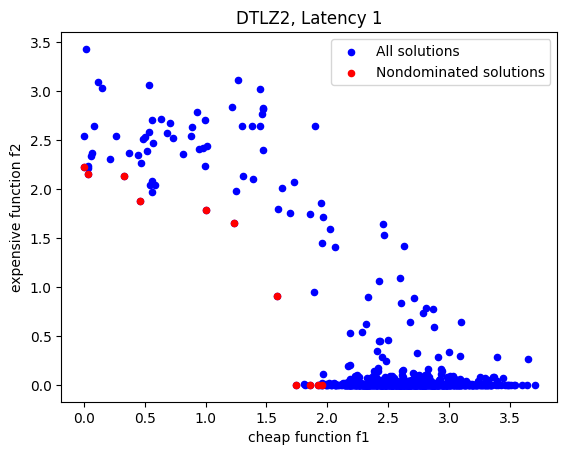

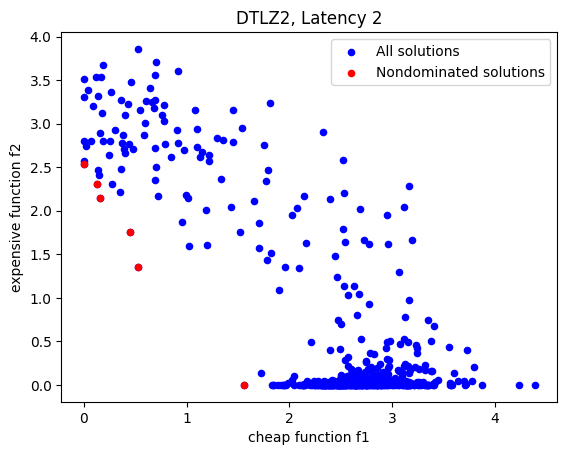

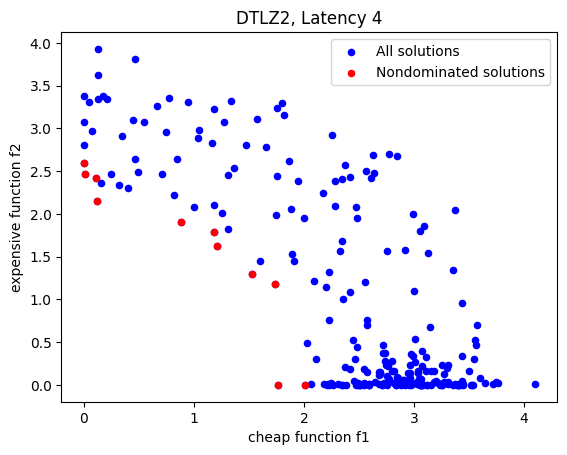

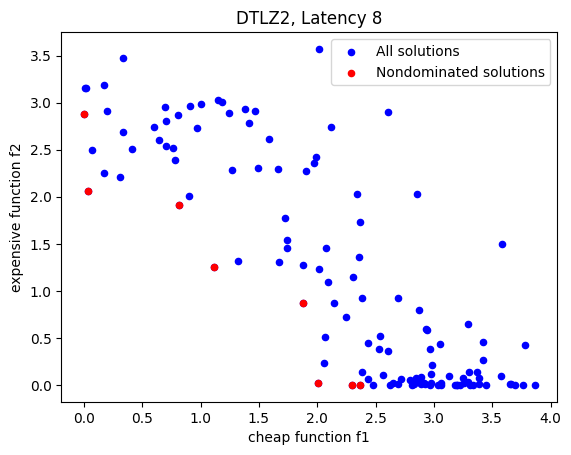

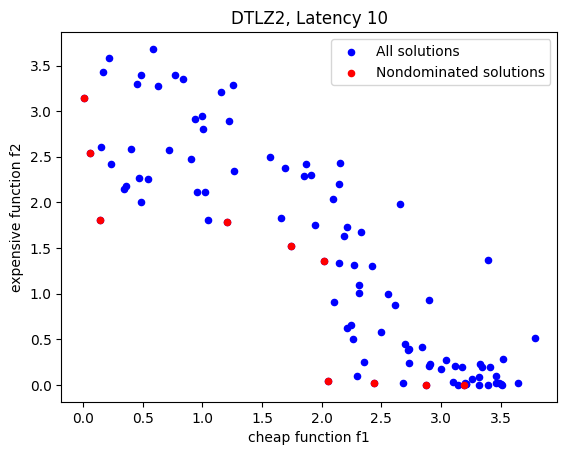

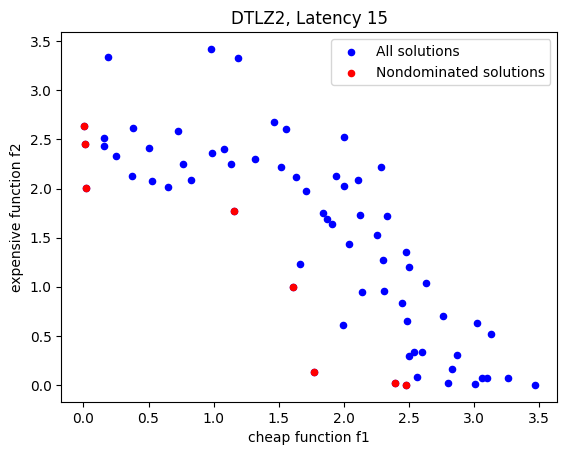

In [ ]:
# %matplotlib inline
# # the FunctionValue is from archive A's right 2 columns (FunctionValue of f_nex, FunctionValue of f_ex)

# # Scatter plot of all solutions (color: blue)
# plt.scatter(A[:, no_var], A[:, no_var + 1], label='All solutions', s=20, c='blue')

# # Scatter plot of nondominated solutions (color: red)
# plt.scatter(PF_A[:, no_var], PF_A[:, no_var + 1], label='Nondominated solutions', s=20, c='red')

# plt.title("{}, Latency = {}".format(Problem,latency))
# plt.legend()
# plt.xlabel('cheap function f1')
# plt.ylabel('expensive function f2')
# plt.show()

def plot_latency(latency, A, PF_A):
    # Scatter plot of all solutions (color: blue)
    plt.scatter(A[:, 0], A[:, 1], label='All solutions', s=20, c='blue') # 0802從no_var:跟no_var+1改成0,1

    # Scatter plot of nondominated solutions (color: red)
    plt.scatter(PF_A[:, 0], PF_A[:, 1], label='Nondominated solutions', s=20, c='red')

    plt.title("{}, {}".format(Problem, latency))
    plt.legend()
    plt.xlabel('cheap function f1')
    plt.ylabel('expensive function f2')

    # Save the data used to generate the plot
    np.save(os.path.join(problem_directory, f'{Problem} {no_var}var {latency} A_latency_{latency}.npy'), A)
    np.save(os.path.join(problem_directory, f'{Problem} {no_var}var {latency} PF_A_latency_{latency}.npy'), PF_A)

    # Save the plot as an image (optional)
    plt.savefig(os.path.join(problem_directory, f'{Problem} {no_var}var {latency} Pareto_Front_plot.png'))
    plt.show()
    plt.close()  # Close the current plot to avoid overlapping plots

# Iterate through the solutions_dict and plot for each latency
for latency, data in solutions_dict.items():
    A = data['A']
    PF_A = data['PF_A']
    plot_latency(latency, A, PF_A)

In [ ]:
## the 21st run results of A and PF_A from each latency before nomalised (modify the file name based on latency)
# A_loaded = np.load('A_latency_Latency 15.npy')
# PF_A_loaded = np.load('PF_A_latency_Latency 15.npy')

# # Now you can inspect the contents of the loaded arrays
# print("Loaded A:")
# print(A_loaded)

# print("Loaded PF_A:")
# print(PF_A_loaded)

### Attainment and Hypervolume

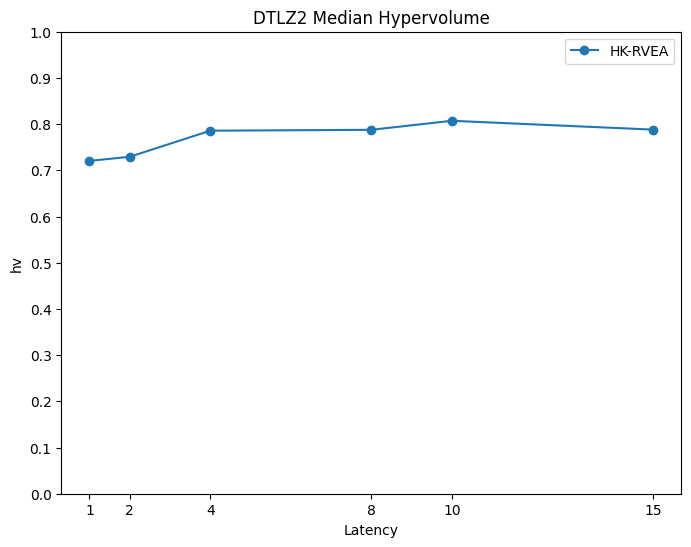

In [ ]:
# line plot of median hypervolume
plt.figure(figsize=(8, 6))
# plt.plot(Latencies, hkrvea_hv,marker = 'o')
plt.plot(Latencies, hkrvea_hypervolumes_median, label = 'HK-RVEA', marker = 'o')
plt.legend()
plt.xlabel('Latency')
plt.ylabel('hv')
plt.title(f'{Problem} Median Hypervolume')
plt.xticks(Latencies)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0,1)
x_positions = range(len(Latencies))
plt.savefig(os.path.join(problem_directory, f'{Problem} {no_var}var Median Hypervolume.png'))
plt.show()

### eaf

In [ ]:
pip install git+https://github.com/auto-optimization/eafpy.git

  Cloning https://github.com/auto-optimization/eafpy.git to /tmp/pip-req-build-e14pgwmb
  Running command git clone --filter=blob:none --quiet https://github.com/auto-optimization/eafpy.git /tmp/pip-req-build-e14pgwmb
  Resolved https://github.com/auto-optimization/eafpy.git to commit b1b6edd5f8b0e943110f0c6f5be5b4e889381d09
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for eafpy: filename=eafpy-0.0.0-cp310-cp310-linux_x86_64.whl size=211743 sha256=df9319f57669ade59b3cba9e3a985f7804f2a1d8b7b9449cb560f04cc98f3f8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-5uqz7tev/wheels/02/7a/e6/fce8e768c162b2dc99b6d3426d4c71d63044250400e74f763d
Successfully built eafpy


In [ ]:
import eafpy as eaf

In [ ]:
for latency_key, median_PF_A_all in median_pareto_front_dict.items():
    # Create a new figure for each latency
    # eaf.figure()
    parts = latency_key.split()

    # Get the last part, which should be the number
    latency_number = int(parts[-1])
    new_column = np.full((21, 1), latency_number)

    # Horizontally stack the new column with the original array
    PF_A_with_column = np.hstack((median_PF_A_all, new_column))
    print("median_PF_A_all")
    print(median_PF_A_all)

    # Plot the median Pareto fronts for the current latency
    plot = eaf.plot_datasets(PF_A_with_column, type="points, lines")

    # Set the title and other layout options
    layout_kwargs = {'title': f'{Problem} Latency = {latency_key}', 'width': 800, 'height': 800}
    plot.update_layout(**layout_kwargs)

    # Show the plot
    plot.show()
    # plot.savefig(f'{Problem} Latency = {latency}'s median attainment.png')

ValueError: ignored

In [ ]:
import rpy2

In [ ]:
# import os
# ## Uncomment this if you suffer from this bug in cffi 1.13.0
# ## https://bitbucket.org/rpy2/rpy2/issues/591/runtimeerror-found-a-situation-in-which-we
# #os.environ['RPY2_CFFI_MODE'] = "API"
# os.environ['R_HOME'] =  "C:/PROGRA~1/R/R-43~1.1"
# os.environ['R_USER'] = "C:/Users/user/AppData/Local/R/win-library/4.3/eaf"

# # Tested with rpy2 2.9.2-1 and 3.2.6
# import numpy as np
# from rpy2.robjects.packages import importr, isinstalled, PackageNotInstalledError
# from rpy2.robjects import r as R
# from rpy2.robjects import numpy2ri
# from rpy2.robjects.vectors import StrVector
# numpy2ri.activate()
# from rpy2.interactive import process_revents
# # process_revents.start()

# def install_rpackages(packages):
#     if not isinstance(packages, list):
#         packages = [ packages ]
#     utils = importr('utils') # import R's utility package
#     # Selectively install what needs to be installed.
#     names_to_install = [x for x in packages if not isinstalled(x)]
#     if len(names_to_install) > 0:
#         print(f"Installing packages: {names_to_install}")
#         utils.install_packages(StrVector(names_to_install), repos = "https://cloud.r-project.org", verbose=True)

# try:
#     eaf = importr("eaf")
# except PackageNotInstalledError as e:
#     install_rpackages("eaf")
#     eaf = importr("eaf") # Retry after install

# path = R('system.file(package="eaf", "extdata")')[0] + "/"
# alg1 = eaf.read_data_sets_(path + "ALG_1_dat.xz")
# alg1 = np.asarray(alg1)
# alg2 = np.asarray(eaf.read_data_sets_(path + "ALG_2_dat.xz"))

# eaf.eafplot(alg1[:, 0:2], sets=alg1[:,2])

# input("Press ENTER to see next plot: ")

# eaf.eafdiffplot(alg1, alg2, title_left="A", title_right="B")

# try

In [ ]:
# X_train =
# kmeans = KMeans(n_clusters=0) # use kmeans to randomly select 500 data points on input data X_train
# kmeans.fit(X_train)
# idx = kmeans.labels_
# idx

In [ ]:
# def function(a):
#   maxfee=13
#   fee=0
#   count = 0
#   while fee < maxfee:
#     fee += 2
#     count += 1
#   c = fee + 100
#   d = fee + 200
#   return c, d


In [ ]:
# b,_ = function(3)
# b

In [ ]:
# shuffle = np.random.permutation(10) # 0 ~ 9
# shuffle

In [ ]:
# competitors = shuffle.reshape((10 // 2, 2))
# competitors

In [ ]:
# winners = []
# fitness = np.array([[9],
#  [0],
#  [7],
#  [2],
#  [5],
#  [4],
#  [3],
#  [6],
#  [1],
#  [8]])
# fitness

In [ ]:
# fitness_comp = fitness[competitors] #根據competitors inde排出的fitness value
# fitness_comp
# # fitness[3] = 2, fitness[5] = 4
# # fitness[9] = 8, fitness[6] = 3
# # fitness[7] = 6, fitness[2] = 7
# # fitness[1] = 0, fitness[0] = 9
# # fitness[8] = 1, fitness[4] = 5

In [ ]:
# comp = np.array([[9,5],[8,3],[1,7],[2,10],[4,6]])
# comp

In [ ]:
# idmap = np.array([0,5])
# idmap

In [ ]:
# winID = np.array([[1],[1],[0],[1],[1]])
# winID

In [ ]:
# idmap[winID]
# c = np.array([0,1,2,3,4])
# idmap[winID]+c

In [ ]:
# idmap1 = np.array([[5],[6],[2],[8],[9]])
# idmap1

try

In [ ]:
# a = np.array([[10],[1],[8],[3],[6],[5],[4],[7],[2],[9]])
# a

In [ ]:
# print("a dim",a.ndim)

In [ ]:
# b = np.array([[7,0],[1,3],[4,5],[2,6],[8,9]])
# b

In [ ]:
# a[b]

In [ ]:
# winFit = np.max(a[b],axis=1)
# winFit

In [ ]:
# winID = np.argmax(a[b],axis=1)
# winID

In [ ]:
# idMap = np.array([0,5])
# idMap

In [ ]:
# idMapwinID = np.squeeze(np.array([idMap[w] for w in winID]))
# idMap1 = idMapwinID + np.arange(b.shape[0])
# winners = b.T.reshape(1,-1)[0,idMap1]

In [ ]:

# winners

In [ ]:
# b_comp = np.array([[7,0],[1,2],[8,9],[10,11],[12,13],[14,15],[16,17],[18,19],[3,5],[6,4]])
# b_comp

In [ ]:
# c_rT = b_comp.reshape(2,10).T
# c_rT

In [ ]:
# winFit = np.max(a[b], axis=1)
# print("winFit", winFit)
# winID=np.argmax(a[b], axis=1)
# print("winID",winID)
# idMap = winFit[winID]
# print("idMap",idMap)
# actual_indices = np.zeros_like(winID)
# for i in range(len(winID)):
#     actual_indices[i] = np.argwhere(a == a_b[i, winID[i]])[0][0]

# actual_indices = np.array(actual_indices)
# print("actual_indices",actual_indices)

#winFit

In [ ]:
# output of winID should be 7 2 5 6

In [ ]:
# winID=np.argmax(a[b], axis=1)
# winID

In [ ]:
# selected_winFit = winFit[winID]
# selected_winFit

In [ ]:
# a_b=a[b]
# a_b

In [ ]:
# actual_indices = np.zeros_like(winID)
# for i in range(len(winID)):
#     actual_indices[i] = np.argwhere(a == a_b[i, winID[i]])[0][0]

# actual_indices = np.array(actual_indices)
# actual_indices

In [ ]:
# idMap = np.arange(1,4,1) * 8 / 4
# idMap

In [ ]:
# idMap1 = idMap[winID] + np.arange(0, b.shape[0] + 1)
# idMap1

In [ ]:
# winners=[]
# winners = np.concatenate((winners, b[idMap1.astype(int)-1]), axis=0)

In [ ]:
# idMap1 = idMap[winID] + np.arange(18)
# idMap1

In [ ]:
# appendix codes